In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

from optbinning import BinningProcess

# set col width
pd.set_option('display.max_colwidth', 100)

# set plot style
sns.set_style('whitegrid')

# set palette
sns.set_palette('Set1')

In [2]:
df = pd.read_csv('../raw-data/dseb63_application_train.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.set_index('SK_ID_CURR', inplace=True)
df_copy = df.copy()
df.head()

TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
SK_ID_CURR                                                       
278621           0         Cash loans           F            N   
139008           0         Cash loans           F            N   
138348           0         Cash loans           M            N   
64140            0         Cash loans           M            N   
219374           0         Cash loans           M            Y   

           FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
SK_ID_CURR                                                               
278621                   N             0          270000.0   1293502.5   
139008                   Y             0          135000.0    312682.5   
138348                   Y             0          121500.0    513000.0   
64140                    Y             0           99000.0    490495.5   
219374                   Y             0          360000.0   1530000.0   

            AMT_ANNUITY  AMT_GOODS_PRICE  ... FLAG_DOCUMENT_18  \
SK_ID_CURR                                ...                    
278621          35698.5        1129500.0  ...                0   
139008          29686.5         297000.0  ...                0   
138348          21865.5         513000.0  ...                0   
64140           27517.5         454500.0  ...                0   
219374          42075.0        1530000.0  ...                0   

           FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
SK_ID_CURR                                                      
278621                    0                0                0   
139008                    0                0                0   
138348                    0                0                0   
64140                     0                0                0   
219374                    0                0                0   

           AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
SK_ID_CURR                                                         
278621                            0.0                        0.0   
139008                            NaN                        NaN   
138348                            0.0                        0.0   
64140                             0.0                        0.0   
219374                            0.0                        0.0   

            AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
SK_ID_CURR                                                          
278621                             0.0                        0.0   
139008                             NaN                        NaN   
138348                             0.0                        0.0   
64140                              0.0                        0.0   
219374                             0.0                        0.0   

            AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
SK_ID_CURR                                                         
278621                            0.0                         0.0  
139008                            NaN                         NaN  
138348                            0.0                         0.0  
64140                             1.0                         1.0  
219374                            0.0                         0.0  

[5 rows x 121 columns]

# EDA

## Outliers

In [3]:
num_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = df.select_dtypes(include='object').columns.tolist()

cols_to_plot = df[num_cols].var()[df[num_cols].var() > 0.1].index.tolist()
print(f'Plotting {len(cols_to_plot)} columns: {cols_to_plot}')
ncol, nrow = 3, len(cols_to_plot)//3 + 1

Plotting 28 columns: ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_3', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']


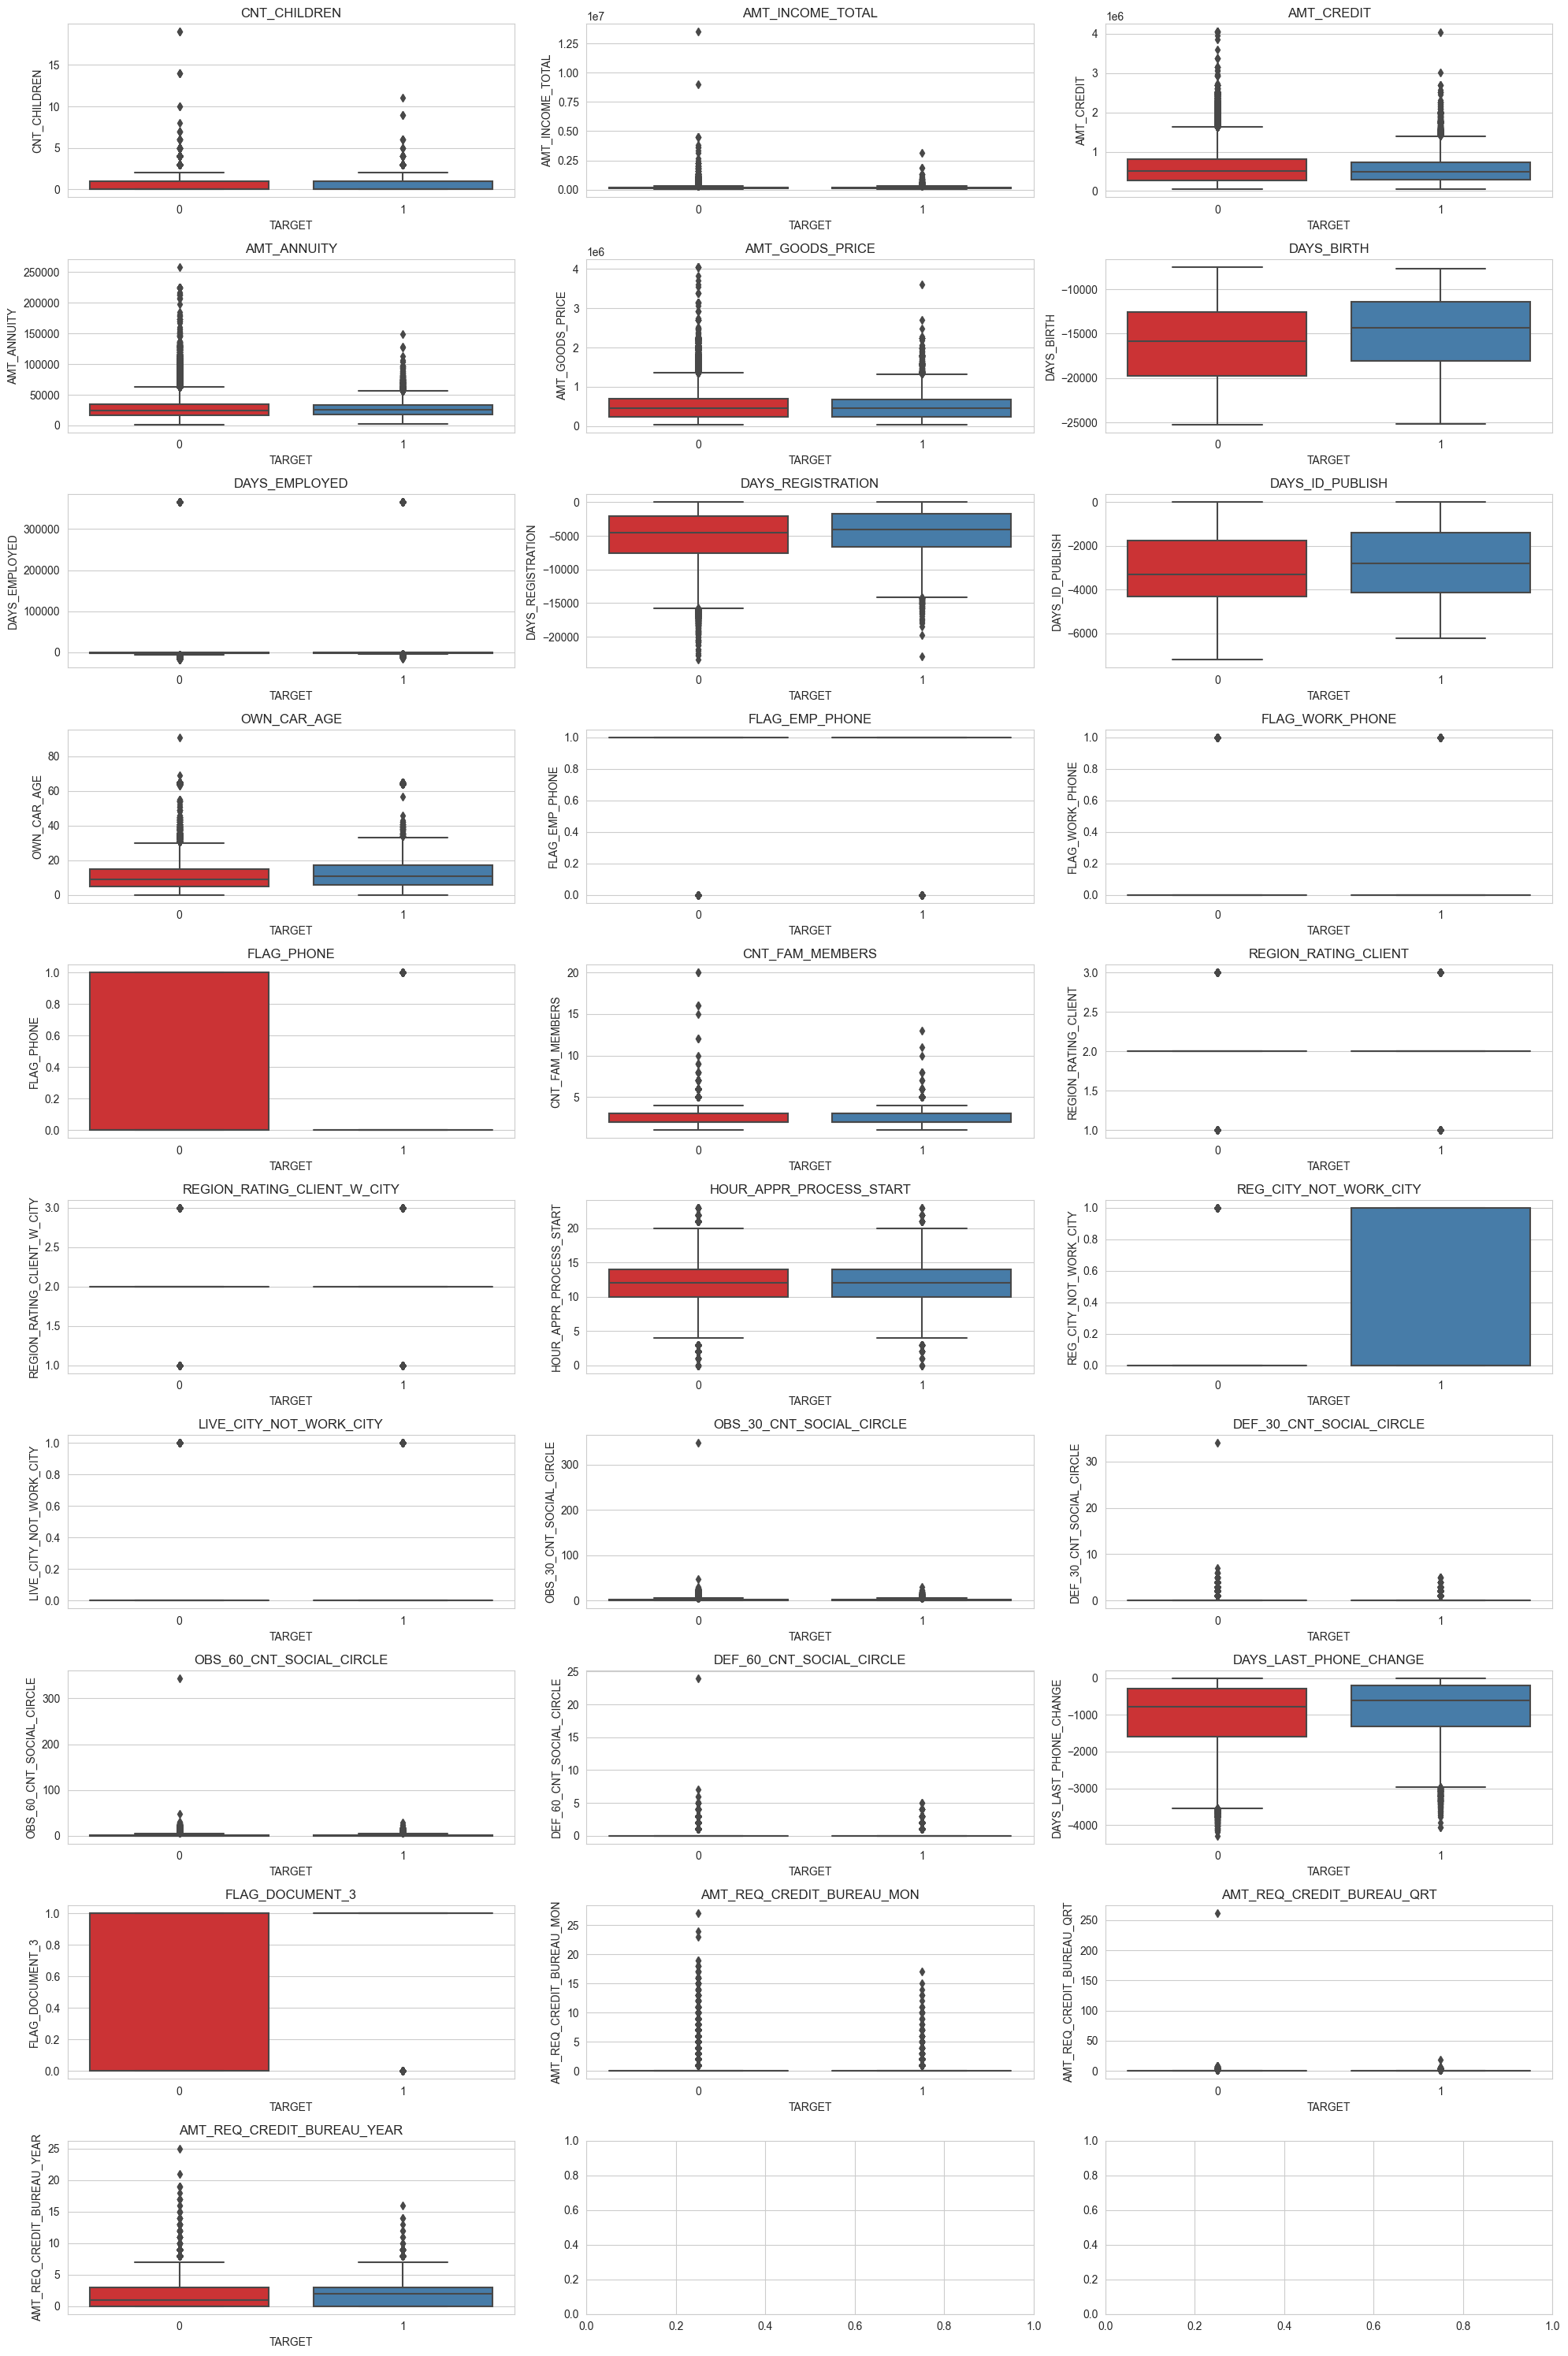

In [4]:
# Boxplot of numerical features with hue = target
fig, ax = plt.subplots(nrow, ncol, figsize=(20, 30))

for i, col in enumerate(cols_to_plot):
    sns.boxplot(x='TARGET', y=col, data=df, ax=ax[i//ncol, i%ncol])
    ax[i//ncol, i%ncol].set_title(col)

plt.tight_layout()
plt.show()

- Đối với khách hàng target = 0: ở những features CNT_CHILDREN, AMT_ANNUITY, AMT_GOODS_PRICE, AMT_CREDIT, OWN_CAR_AGE, họ có số lượng nhiều hơn, giá trị lớn hơn so với khách hàng target = 1.
- Còn với khách hàng target = 1, độ tuổi của họ lại khá là trẻ hơn so với target = 0.

In [5]:
# # Process outliers by clipping
# for col in num_cols:
#     df[col] = df[col].clip(lower=df[col].quantile(0.05), upper=df[col].quantile(0.95))

## Descriptive

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 246009 entries, 278621 to 258328
Columns: 121 entries, TARGET to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 229.0+ MB


In [7]:
# Describe the numerical features
df[num_cols].describe()

TARGET   CNT_CHILDREN  AMT_INCOME_TOTAL    AMT_CREDIT  \
count  246009.000000  246009.000000      2.460090e+05  2.460090e+05   
mean        0.080794       0.416229      1.684589e+05  5.996410e+05   
std         0.272519       0.720664      1.045297e+05  4.030980e+05   
min         0.000000       0.000000      2.565000e+04  4.500000e+04   
25%         0.000000       0.000000      1.125000e+05  2.700000e+05   
50%         0.000000       0.000000      1.462500e+05  5.147775e+05   
75%         0.000000       1.000000      2.025000e+05  8.086500e+05   
max         1.000000      19.000000      1.350000e+07  4.050000e+06   

         AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  \
count  245999.000000     2.457850e+05               246009.000000   
mean    27120.238129     5.389827e+05                    0.020855   
std     14510.634712     3.700520e+05                    0.013818   
min      1615.500000     4.050000e+04                    0.000290   
25%     16506.000000     2.385000e+05                    0.010006   
50%     24903.000000     4.500000e+05                    0.018850   
75%     34654.500000     6.795000e+05                    0.028663   
max    258025.500000     4.050000e+06                    0.072508   

          DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  ...  FLAG_DOCUMENT_18  \
count  246009.000000  246009.000000      246009.000000  ...     246009.000000   
mean   -16038.946343   63852.612441       -4985.222248  ...          0.008130   
std      4361.265483  141306.376949        3521.391396  ...          0.089798   
min    -25229.000000  -17912.000000      -23416.000000  ...          0.000000   
25%    -19682.000000   -2758.000000       -7482.000000  ...          0.000000   
50%    -15755.000000   -1212.000000       -4504.000000  ...          0.000000   
75%    -12418.000000    -288.000000       -2006.000000  ...          0.000000   
max     -7489.000000  365243.000000           0.000000  ...          1.000000   

       FLAG_DOCUMENT_19  FLAG_DOCUMENT_20  FLAG_DOCUMENT_21  \
count     246009.000000     246009.000000     246009.000000   
mean           0.000581          0.000496          0.000309   
std            0.024103          0.022264          0.017574   
min            0.000000          0.000000          0.000000   
25%            0.000000          0.000000          0.000000   
50%            0.000000          0.000000          0.000000   
75%            0.000000          0.000000          0.000000   
max            1.000000          1.000000          1.000000   

       AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
count               212798.000000              212798.000000   
mean                     0.006480                   0.006729   
std                      0.084239                   0.106693   
min                      0.000000                   0.000000   
25%                      0.000000                   0.000000   
50%                      0.000000                   0.000000   
75%                      0.000000                   0.000000   
max                      3.000000                   9.000000   

       AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
count               212798.000000              212798.000000   
mean                     0.034211                   0.266647   
std                      0.204336                   0.911957   
min                      0.000000                   0.000000   
25%                      0.000000                   0.000000   
50%                      0.000000                   0.000000   
75%                      0.000000                   0.000000   
max                      8.000000                  27.000000   

       AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
count              212798.000000               212798.000000  
mean                    0.266920                    1.901127  
std                     0.834132                    1.870269  
min                     0.000000                

In [8]:
# Replace 365243 with NaN
df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)

# Process outliers by clipping
for col in num_cols:
    df[col] = df[col].clip(lower=df[col].quantile(0.01), upper=df[col].quantile(0.99))

df.describe()

TARGET   CNT_CHILDREN  AMT_INCOME_TOTAL    AMT_CREDIT  \
count  246009.000000  246009.000000     246009.000000  2.460090e+05   
mean        0.080794       0.413643     166128.016966  5.969180e+05   
std         0.272519       0.705684      83060.345130  3.919497e+05   
min         0.000000       0.000000      45000.000000  7.641000e+04   
25%         0.000000       0.000000     112500.000000  2.700000e+05   
50%         0.000000       0.000000     146250.000000  5.147775e+05   
75%         0.000000       1.000000     202500.000000  8.086500e+05   
max         1.000000       3.000000     472500.000000  1.852801e+06   

         AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  \
count  245999.000000     2.457850e+05               246009.000000   
mean    26956.017059     5.373208e+05                    0.020859   
std     13672.618920     3.624009e+05                    0.013812   
min      6187.500000     6.750000e+04                    0.002134   
25%     16506.000000     2.385000e+05                    0.010006   
50%     24903.000000     4.500000e+05                    0.018850   
75%     34654.500000     6.795000e+05                    0.028663   
max     70015.500000     1.800000e+06                    0.072508   

          DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  ...  FLAG_DOCUMENT_18  \
count  246009.000000  201685.000000      246009.000000  ...          246009.0   
mean   -16038.189074   -2368.846756       -4973.561203  ...               0.0   
std      4350.874914    2273.672280        3486.624642  ...               0.0   
min    -24415.000000  -11349.000000      -13848.000000  ...               0.0   
25%    -19682.000000   -3174.000000       -7482.000000  ...               0.0   
50%    -15755.000000   -1646.000000       -4504.000000  ...               0.0   
75%    -12418.000000    -766.000000       -2006.000000  ...               0.0   
max     -8261.000000    -111.000000         -49.000000  ...               0.0   

       FLAG_DOCUMENT_19  FLAG_DOCUMENT_20  FLAG_DOCUMENT_21  \
count          246009.0          246009.0          246009.0   
mean                0.0               0.0               0.0   
std                 0.0               0.0               0.0   
min                 0.0               0.0               0.0   
25%                 0.0               0.0               0.0   
50%                 0.0               0.0               0.0   
75%                 0.0               0.0               0.0   
max                 0.0               0.0               0.0   

       AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
count                    212798.0                   212798.0   
mean                          0.0                        0.0   
std                           0.0                        0.0   
min                           0.0                        0.0   
25%                           0.0                        0.0   
50%                           0.0                        0.0   
75%                           0.0                        0.0   
max                           0.0                        0.0   

       AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
count               212798.000000              212798.000000   
mean                     0.031950                   0.235942   
std                      0.175869                   0.640478   
min                      0.000000                   0.000000   
25%                      0.000000                   0.000000   
50%                      0.000000                   0.000000   
75%                      0.000000                   0.000000   
max                      1.000000                   4.000000   

       AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
count              212798.000000               212798.000000  
mean                    0.254260                    1.894444  
std                     0.562545                    1.843018  
min                     0.000000                

In [9]:
# Cols with variance 0
df[num_cols].var()[df[num_cols].var() <= 1e-3]

REGION_POPULATION_RELATIVE      0.000191
FLAG_MOBIL                      0.000000
FLAG_CONT_MOBILE                0.000000
YEARS_BEGINEXPLUATATION_AVG     0.000073
NONLIVINGAPARTMENTS_AVG         0.000231
YEARS_BEGINEXPLUATATION_MODE    0.000074
NONLIVINGAPARTMENTS_MODE        0.000193
YEARS_BEGINEXPLUATATION_MEDI    0.000073
NONLIVINGAPARTMENTS_MEDI        0.000220
FLAG_DOCUMENT_2                 0.000000
FLAG_DOCUMENT_4                 0.000000
FLAG_DOCUMENT_7                 0.000000
FLAG_DOCUMENT_9                 0.000000
FLAG_DOCUMENT_10                0.000000
FLAG_DOCUMENT_11                0.000000
FLAG_DOCUMENT_12                0.000000
FLAG_DOCUMENT_13                0.000000
FLAG_DOCUMENT_14                0.000000
FLAG_DOCUMENT_15                0.000000
FLAG_DOCUMENT_16                0.000000
FLAG_DOCUMENT_17                0.000000
FLAG_DOCUMENT_18                0.000000
FLAG_DOCUMENT_19                0.000000
FLAG_DOCUMENT_20                0.000000
FLAG_DOCUMENT_21

In [10]:
# Describe the categorical features
cat_desc = df[cat_cols].describe()
cat_desc.loc['freq_perc'] = cat_desc.loc['freq'] / len(df)
cat_desc

NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
count                 246009      246009       246009          246009   
unique                     2           3            2               2   
top               Cash loans           F            N               Y   
freq                  222491      161856       162184          170843   
freq_perc           0.904402    0.657927      0.65926        0.694458   

          NAME_TYPE_SUITE NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
count              244963           246009                         246009   
unique                  7                8                              5   
top         Unaccompanied          Working  Secondary / secondary special   
freq               198742           126930                         174522   
freq_perc        0.807865         0.515957                       0.709413   

          NAME_FAMILY_STATUS  NAME_HOUSING_TYPE OCCUPATION_TYPE  \
count                 246009             246009          168903   
unique                     6                  6              18   
top                  Married  House / apartment        Laborers   
freq                  157320             218389           44202   
freq_perc           0.639489           0.887728        0.179676   

          WEEKDAY_APPR_PROCESS_START       ORGANIZATION_TYPE  \
count                         246009                  246009   
unique                             7                      58   
top                          TUESDAY  Business Entity Type 3   
freq                           43128                   54312   
freq_perc                   0.175311                0.220772   

          FONDKAPREMONT_MODE  HOUSETYPE_MODE WALLSMATERIAL_MODE  \
count                  77722          122469             120829   
unique                     4               3                  7   
top         reg oper account  block of flats              Panel   
freq                   58964          120320              52873   
freq_perc           0.239682        0.489088           0.214923   

          EMERGENCYSTATE_MODE  
count                  129317  
unique                      2  
top                        No  
freq                   127434  
freq_perc            0.518005

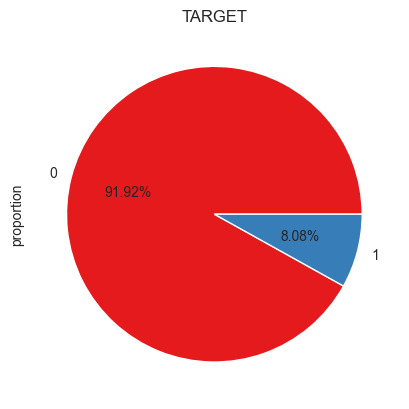

In [11]:
# Describe the target variable and plot
df['TARGET'].value_counts(normalize=True).plot(kind='pie', autopct='%.2f%%')
plt.title('TARGET')
plt.show()

- Mất cân bằng dữ liệu, số lượng khách hàng target = 0 nhiều hơn 10 lần so với khách hàng target = 1.

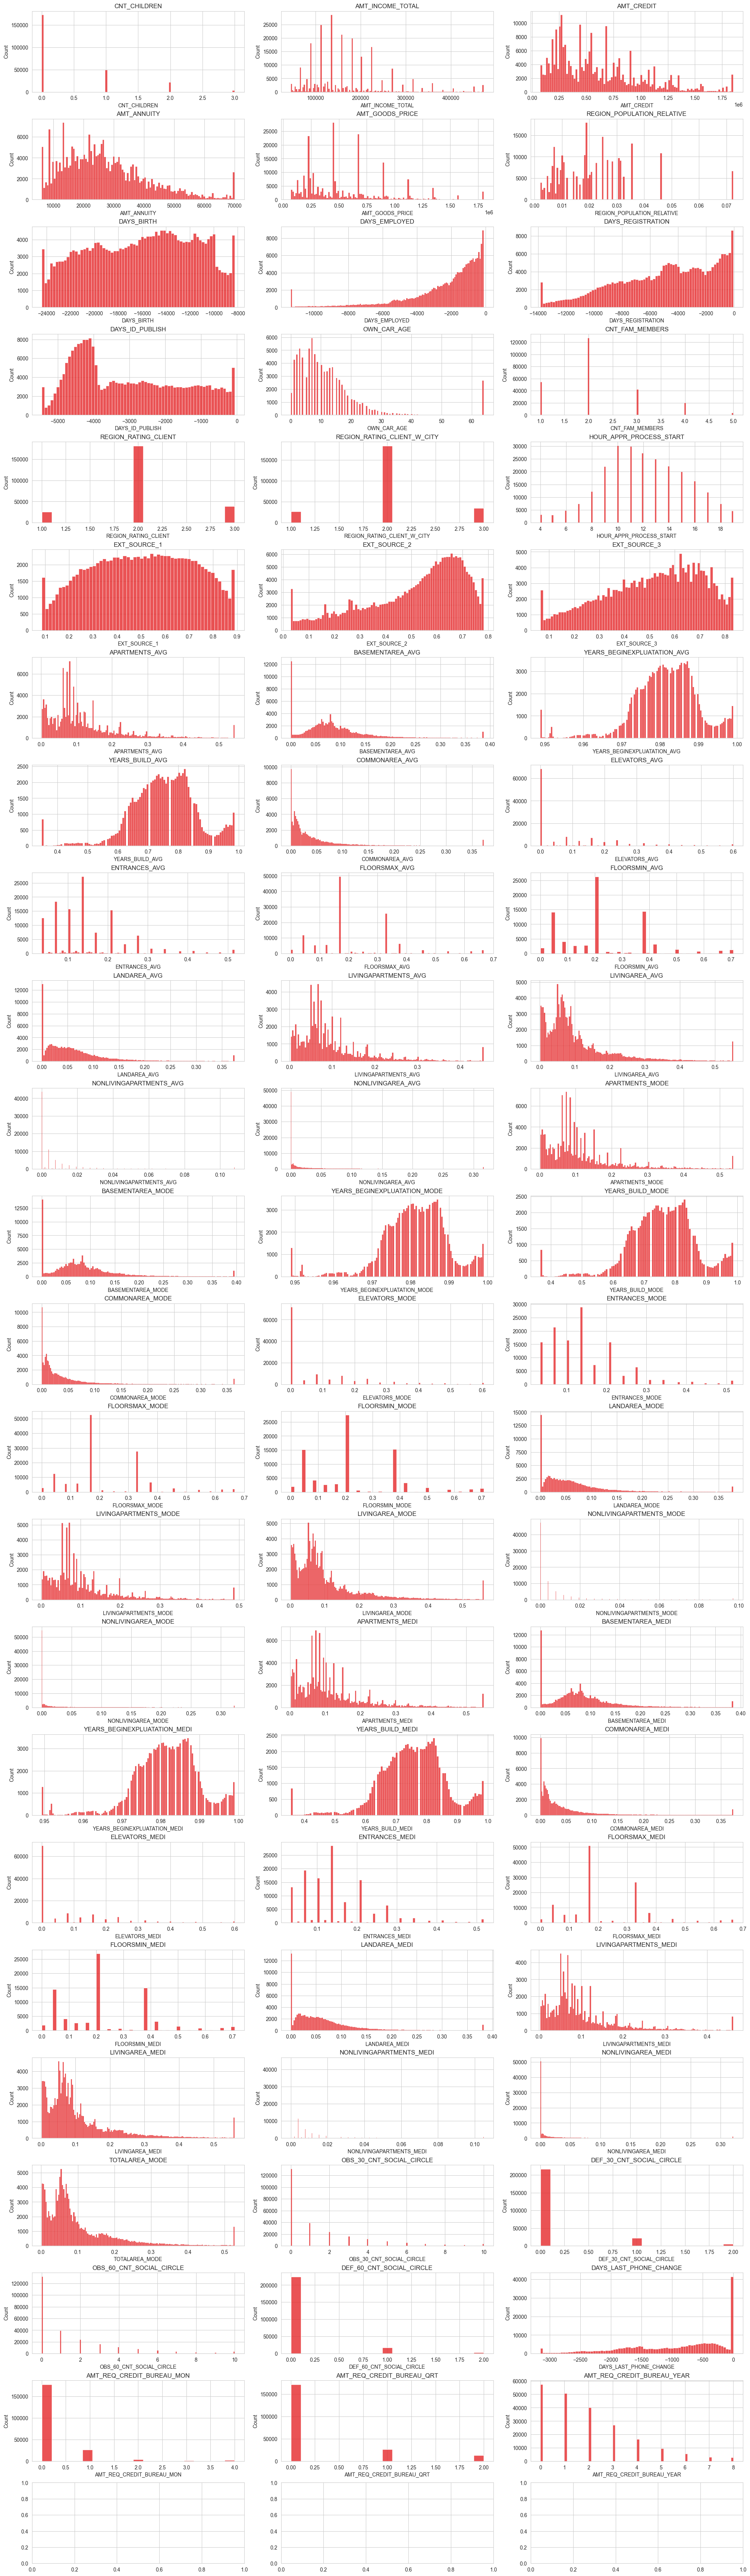

In [12]:
# Plot the histogram of numerical features with nuniques > 2
cols_to_plot = df[num_cols].nunique()[df[num_cols].nunique() > 2].index.tolist()
ncol, nrow = 3, len(cols_to_plot)//3 + 1

fig , axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(20, len(cols_to_plot)), constrained_layout=True)

for ax, column in zip(axes.flatten(), cols_to_plot): 
    sns.histplot(df[column], ax=ax)
    ax.set_title(column)

plt.show()

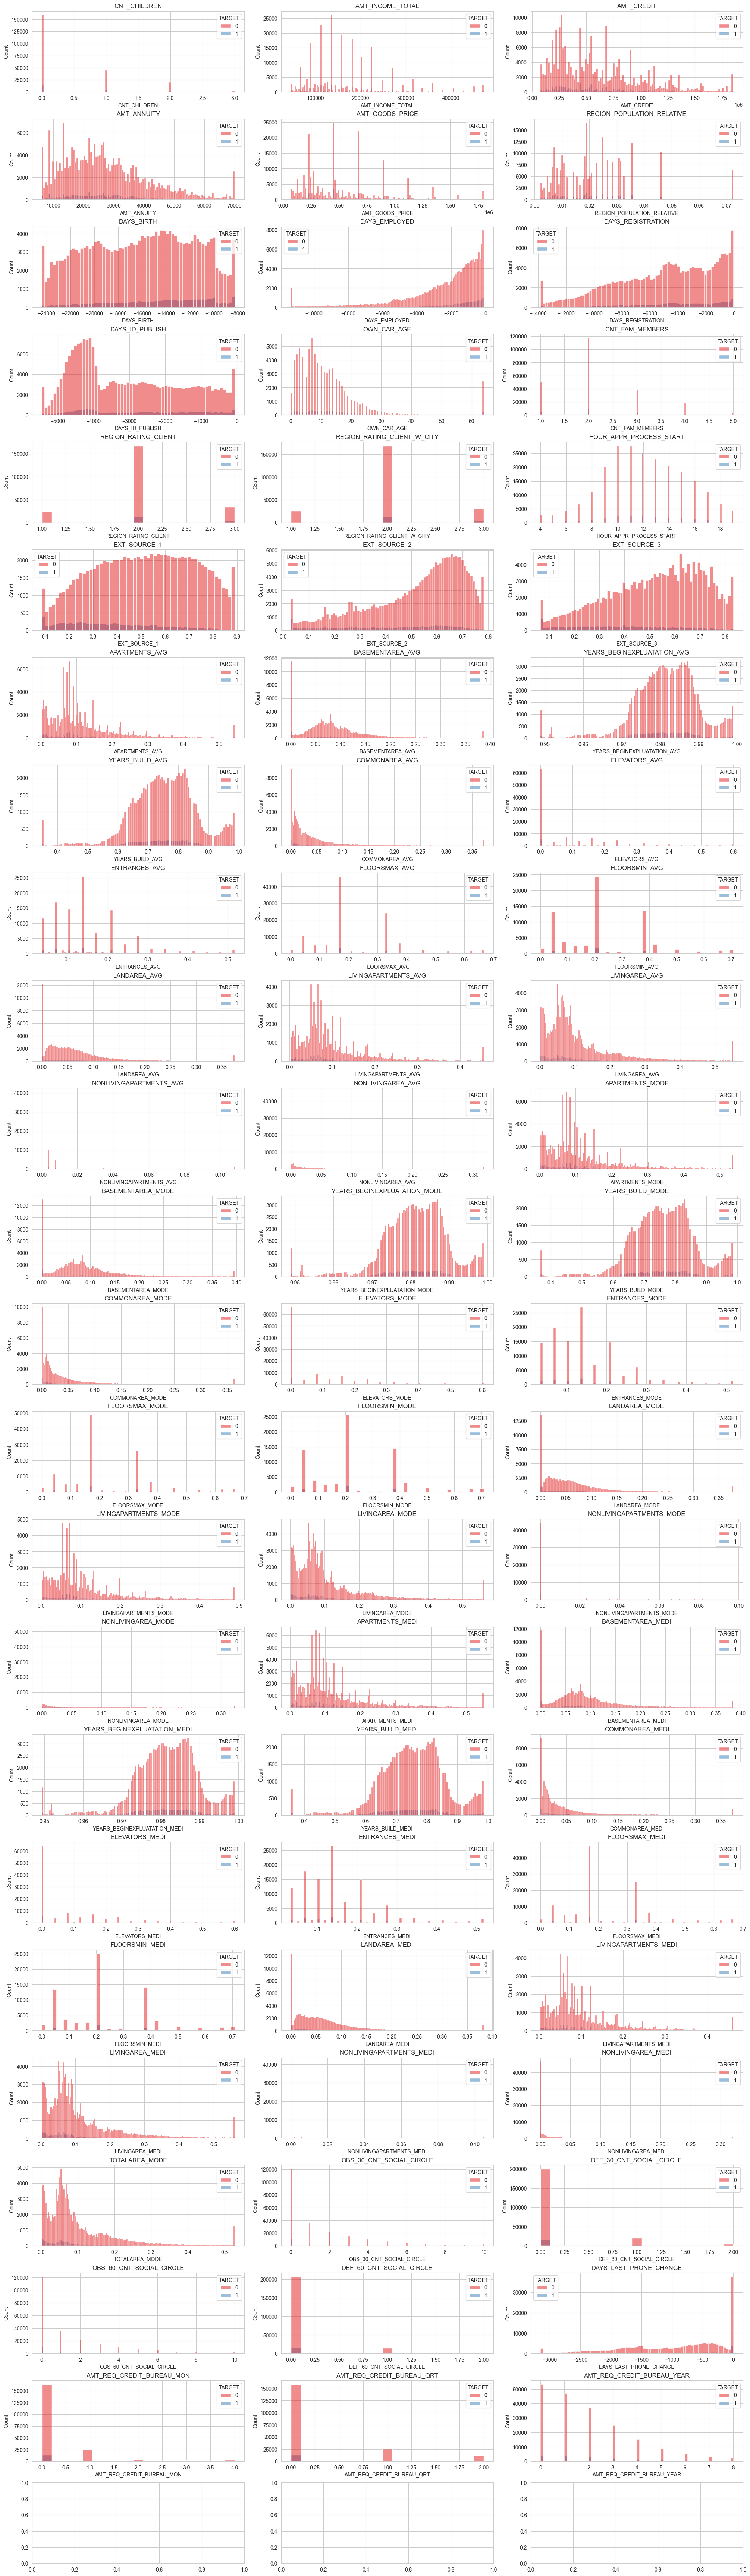

In [13]:
# Plot the histogram of numerical features with nuniques > 2 hue = target
cols_to_plot = df[num_cols].nunique()[df[num_cols].nunique() > 2].index.tolist()
ncol, nrow = 3, len(cols_to_plot)//3 + 1

fig , axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(20, len(cols_to_plot)), constrained_layout=True)

for ax, column in zip(axes.flatten(), cols_to_plot): 
    # histplot with hue
    sns.histplot(df, x=column, hue='TARGET', ax=ax)
    ax.set_title(column)

plt.show()

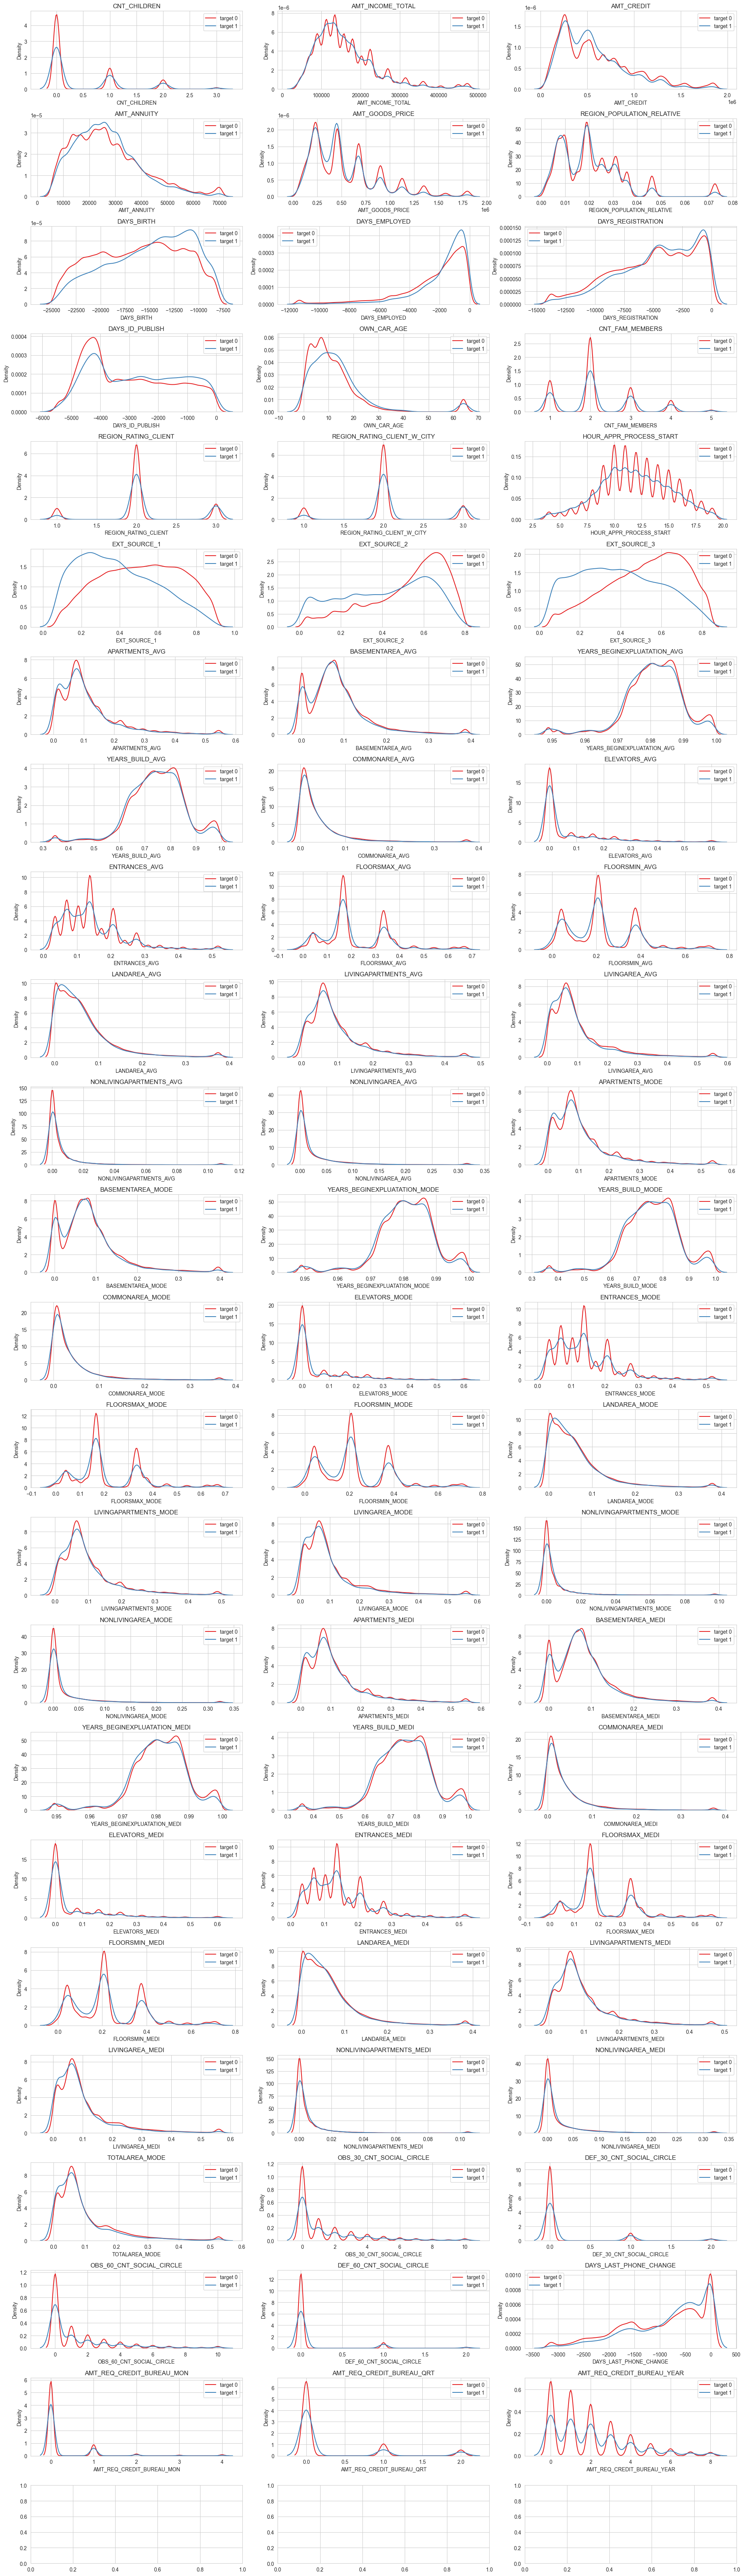

In [14]:
# Plot the distribution of the numerical features with hue = target
fig, ax = plt.subplots(nrow, ncol, figsize=(20, len(cols_to_plot)))

for i, col in enumerate(cols_to_plot):
    # kde plot
    sns.kdeplot(df.loc[df['TARGET'] == 0, col], label='target 0', ax=ax[i//ncol, i%ncol])
    sns.kdeplot(df.loc[df['TARGET'] == 1, col], label='target 1', ax=ax[i//ncol, i%ncol])
    ax[i//ncol, i%ncol].set_title(col)
    ax[i//ncol, i%ncol].legend()

plt.tight_layout()
plt.show()

- Độ tuổi đăng kí vay nhiều nhất nằm vào khoảng 20-40 tuổi cho cả 2 tệp khách hàng.
- 3 biến EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3 là 3 biến có distribution khác nhau ở 2 class 0 và 1, có khả năng phân tách tốt nhất, đặc biệt là EXT_SOURCE_3.
- Các features còn lại có distribution tương đối giống nhau.
-  OBS_60_CNT_SOCIAL_CIRCLE và OBS_30_CNT_SOCIAL_CIRCLE là 2 features giống hệt nhau.

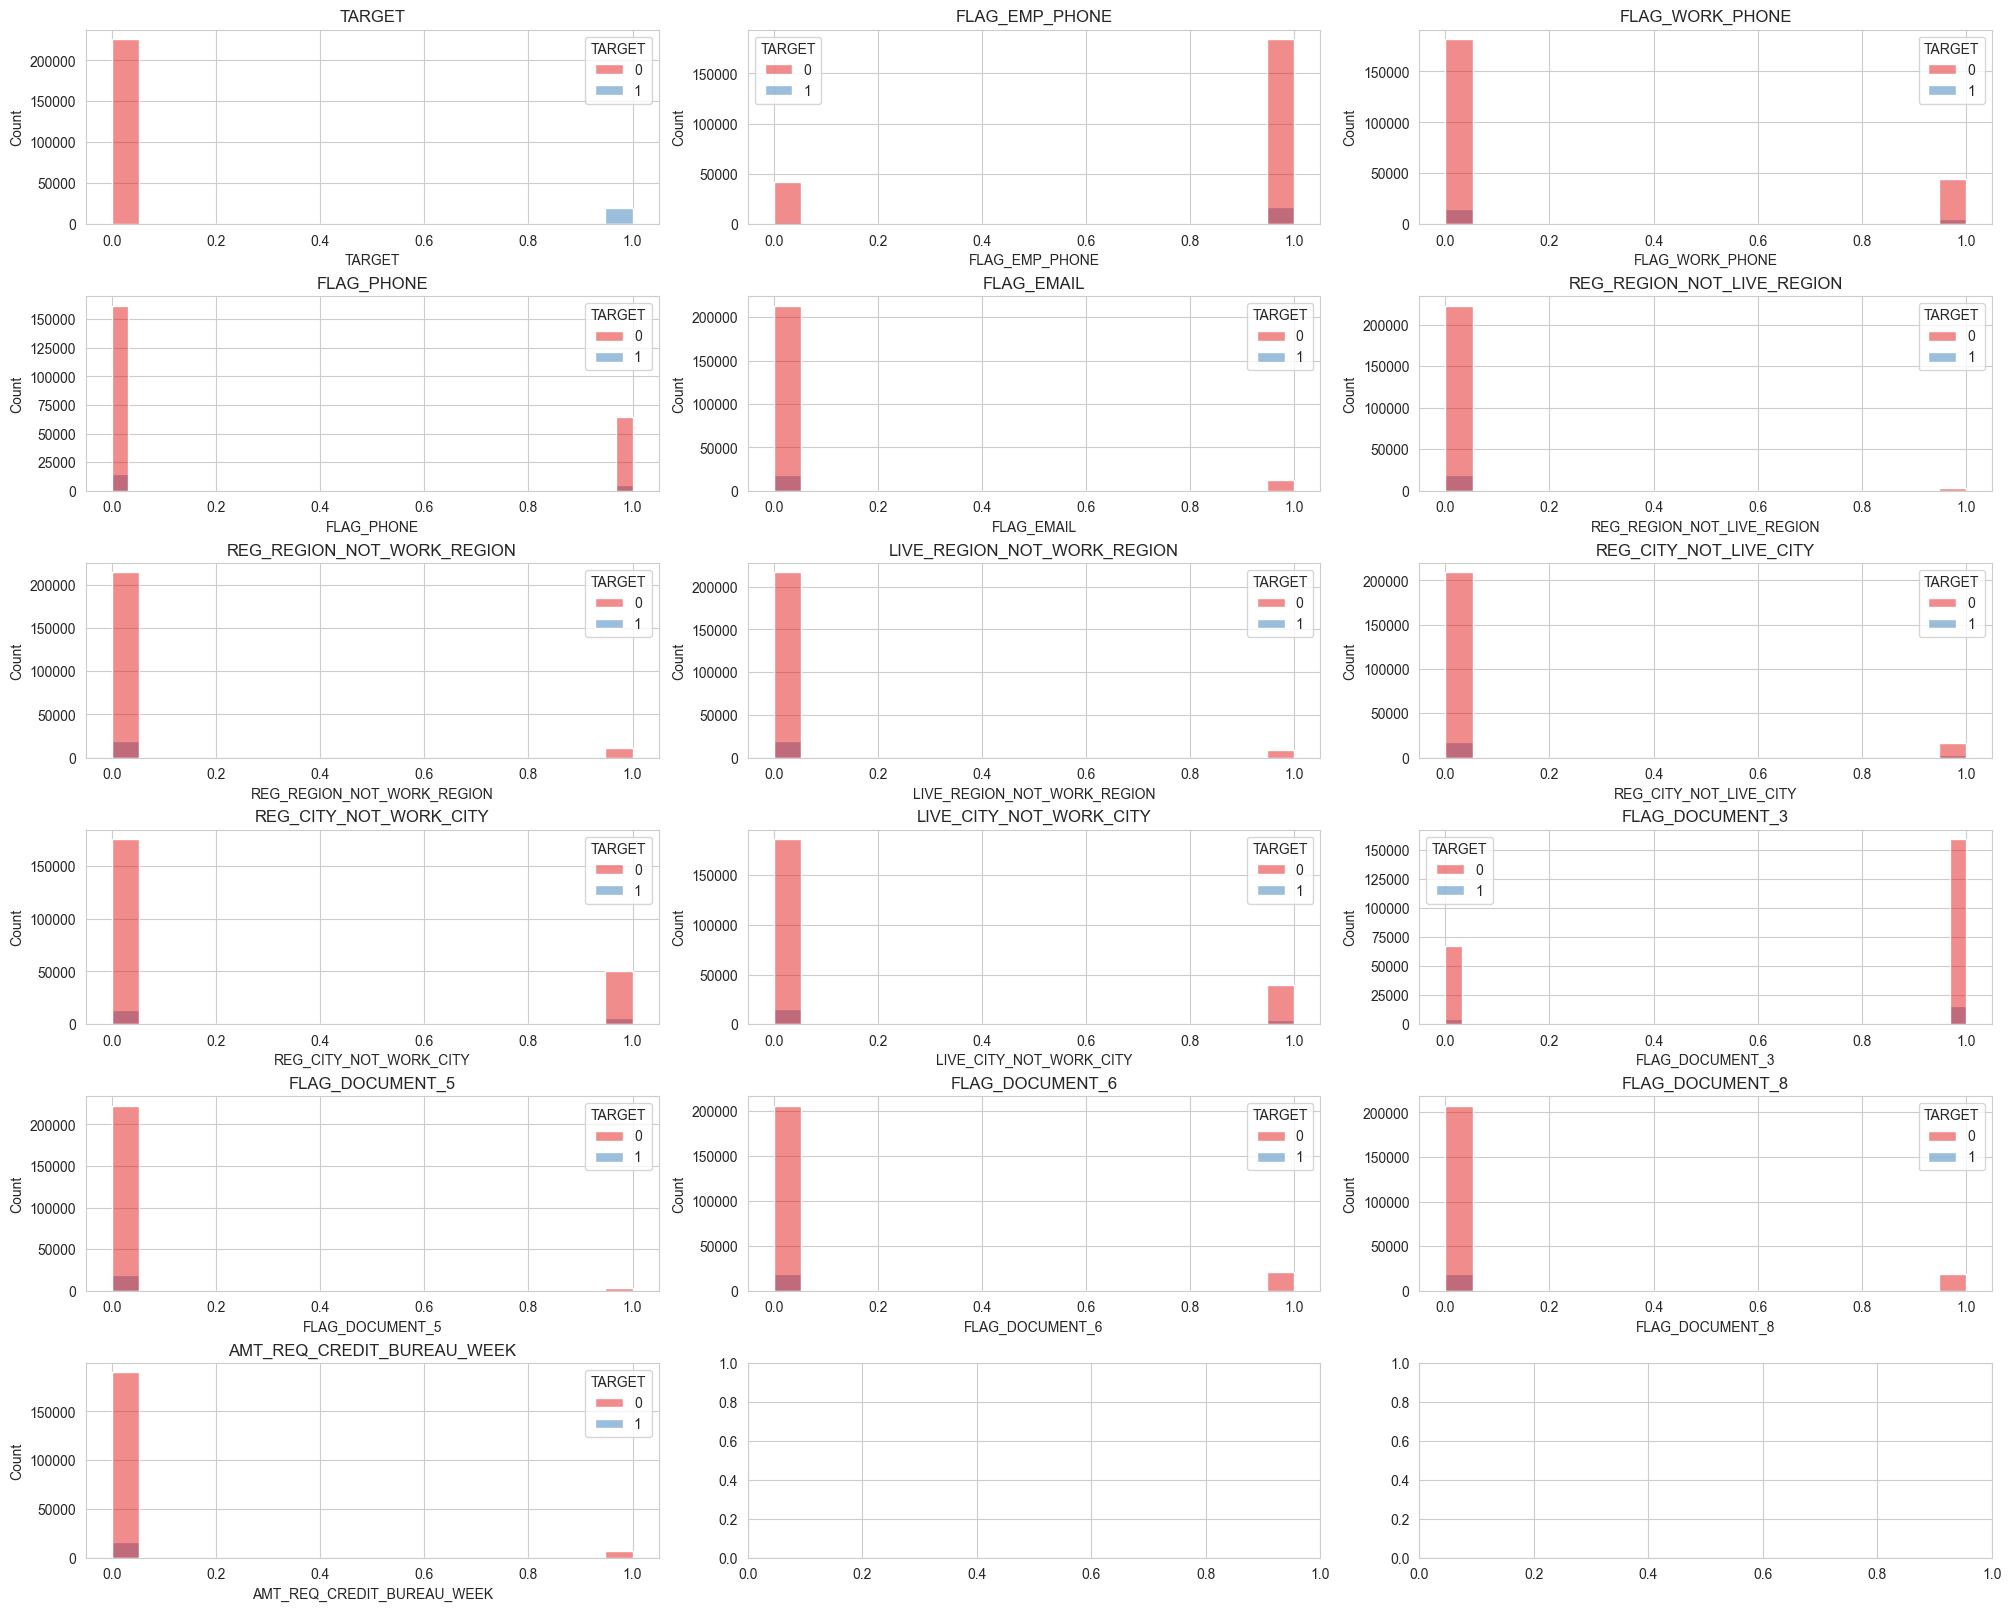

In [15]:
# Plot distribution of binary features with hue = target
cols_to_plot = df[num_cols].nunique()[df[num_cols].nunique() == 2].index.tolist()
ncol, nrow = 3, len(cols_to_plot)//3 + 1

fig , axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(20, len(cols_to_plot)), constrained_layout=True)

for ax, column in zip(axes.flatten(), cols_to_plot):
    sns.histplot(df, x=column, hue='TARGET', ax=ax)
    ax.set_title(column)

plt.show()

Plotting 22 columns: ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_PHONE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_3', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']


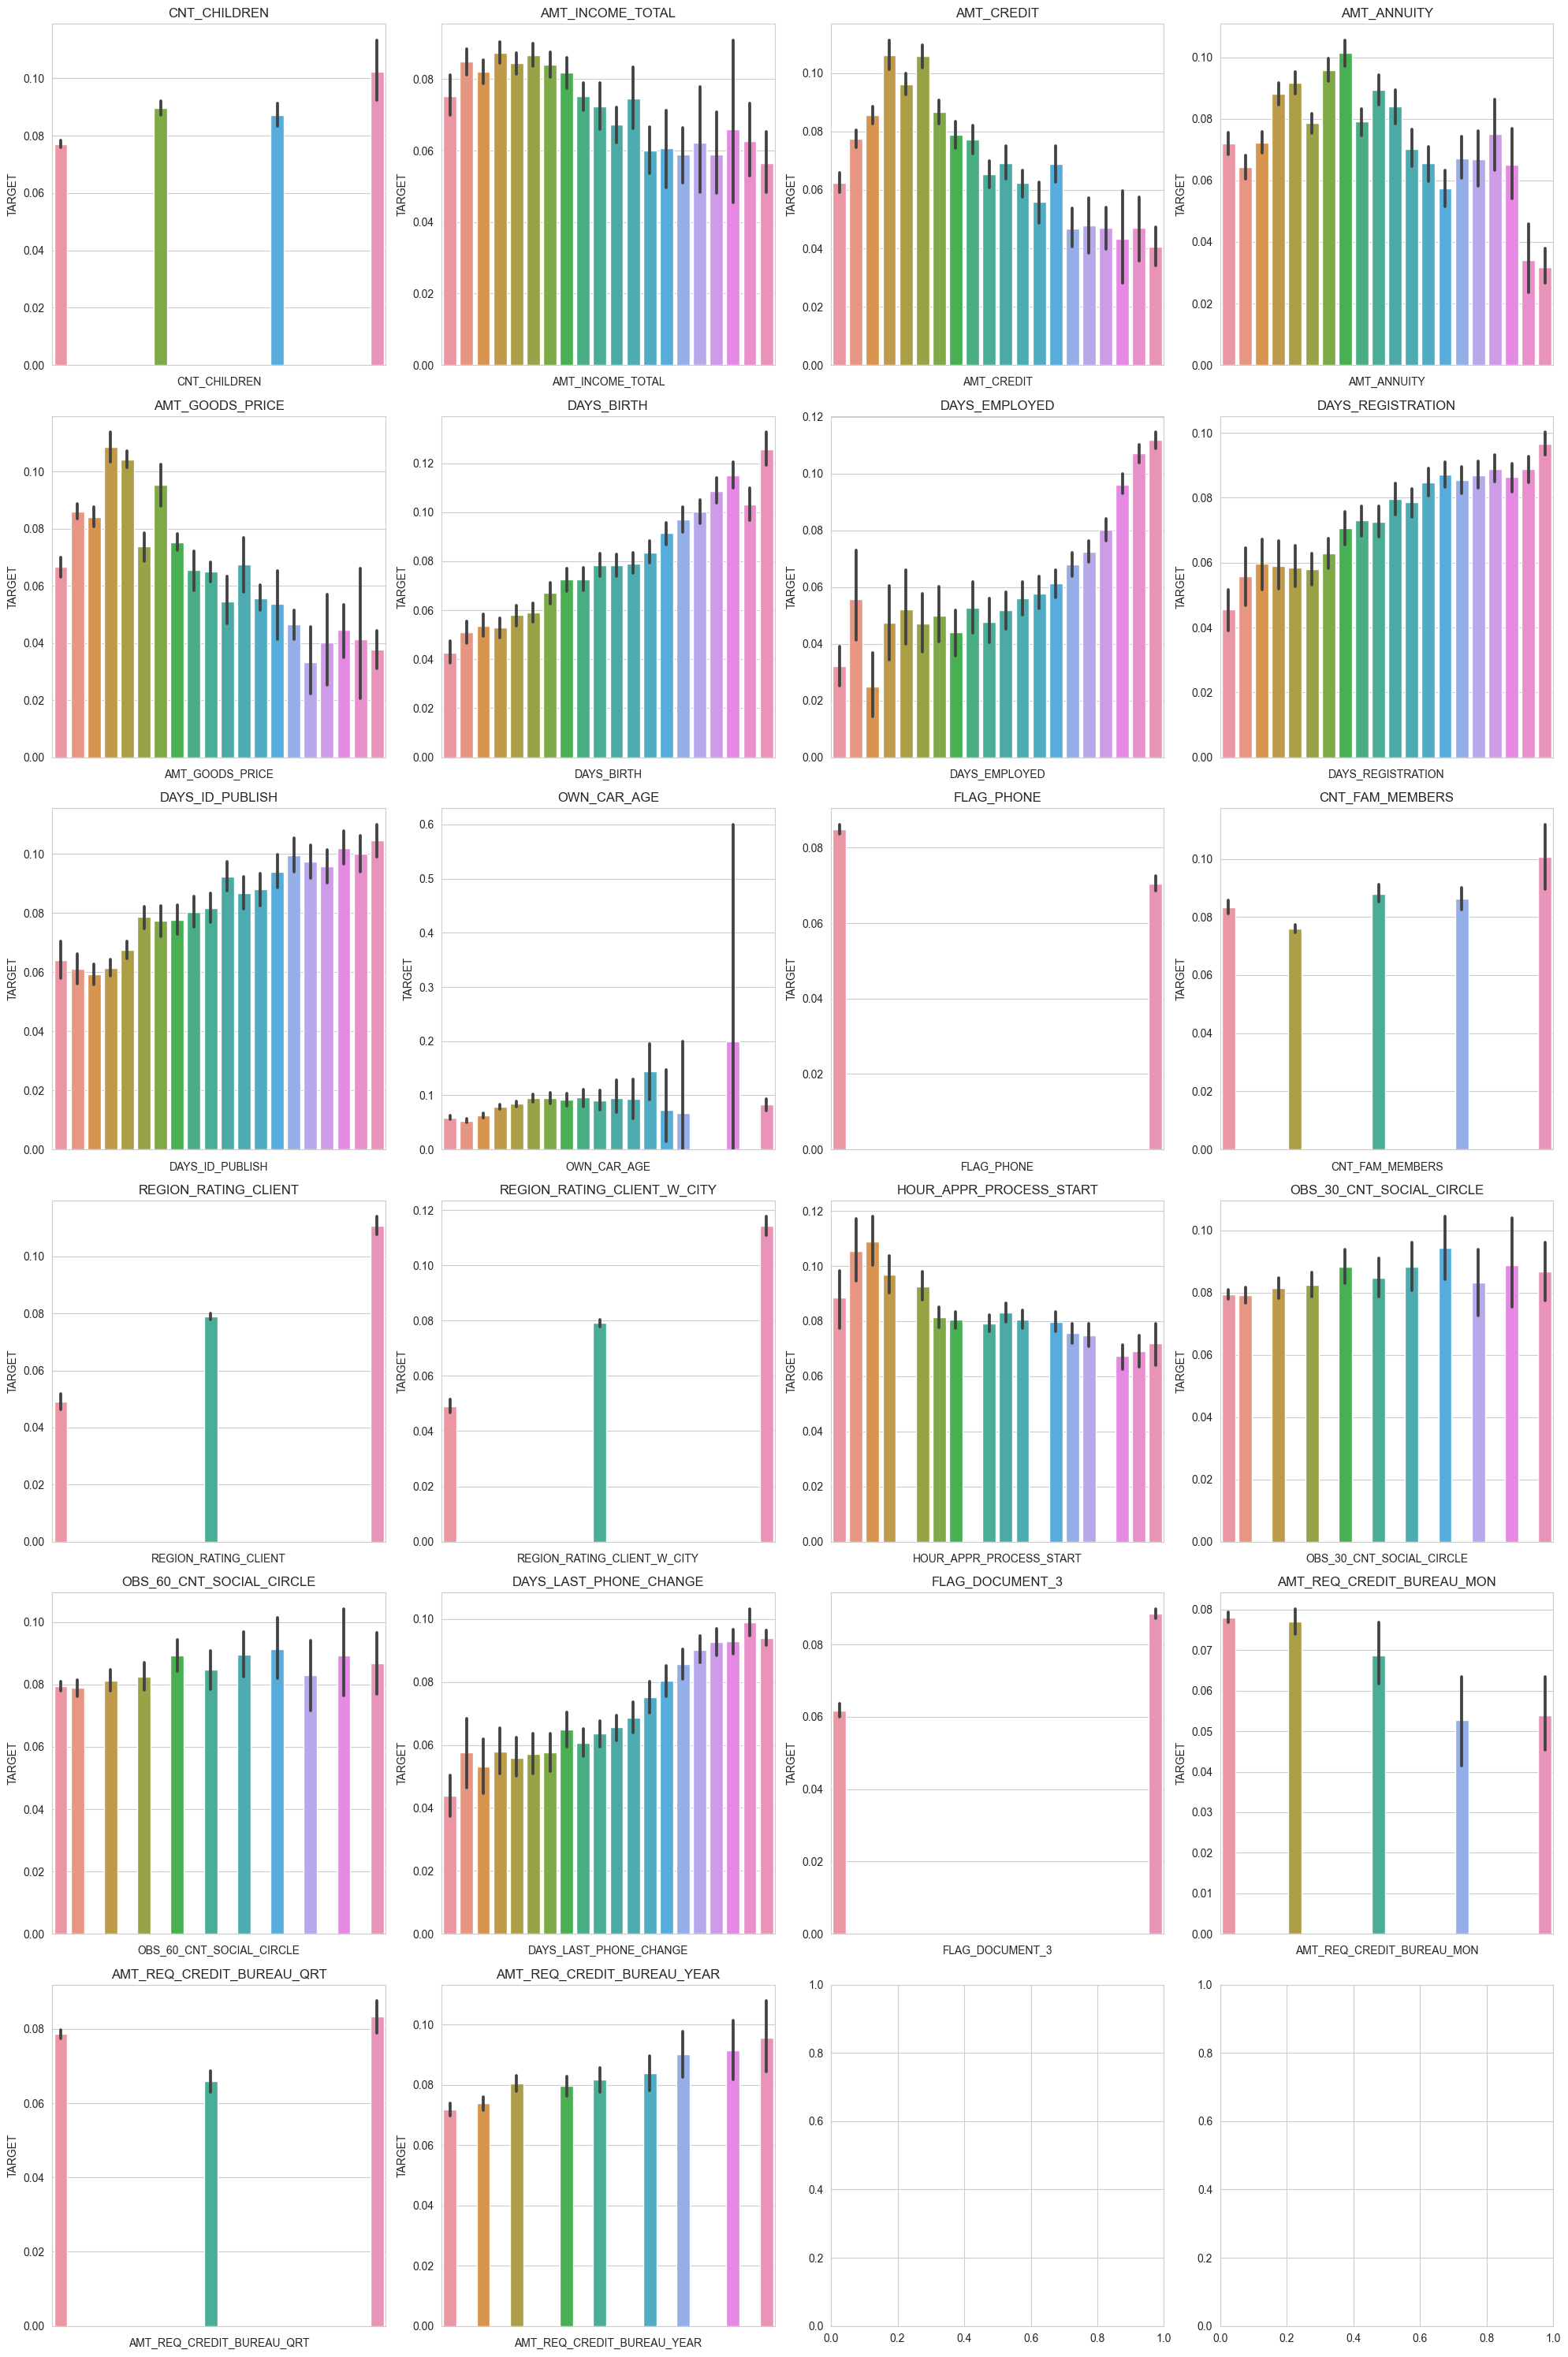

In [16]:
# Plot the distribution of the binned numerical features with hue = target
cols_to_plot = df[num_cols].var()[df[num_cols].var() > 0.2].index.tolist()
print(f'Plotting {len(cols_to_plot)} columns: {cols_to_plot}')
ncol, nrow = 4, len(cols_to_plot)//4 + 1
fig, ax = plt.subplots(nrow, ncol, figsize=(20, 30))

for i, col in enumerate(cols_to_plot):
    val = pd.cut(df[col], bins=20)
    sns.barplot(x=val, y=df['TARGET'], ax=ax[i//ncol, i%ncol])
    ax[i//ncol, i%ncol].set_title(col)
    # ax[i//ncol, i%ncol].tick_params(axis='x', rotation=45)
    # remove xticks
    ax[i//ncol, i%ncol].set_xticklabels([])

plt.tight_layout()
plt.show()

Xuất hiện những feature có mối quan hệ non-linear với target, vd: AMT_INCOME_TOTAL, AMT_ANNUITY, ...

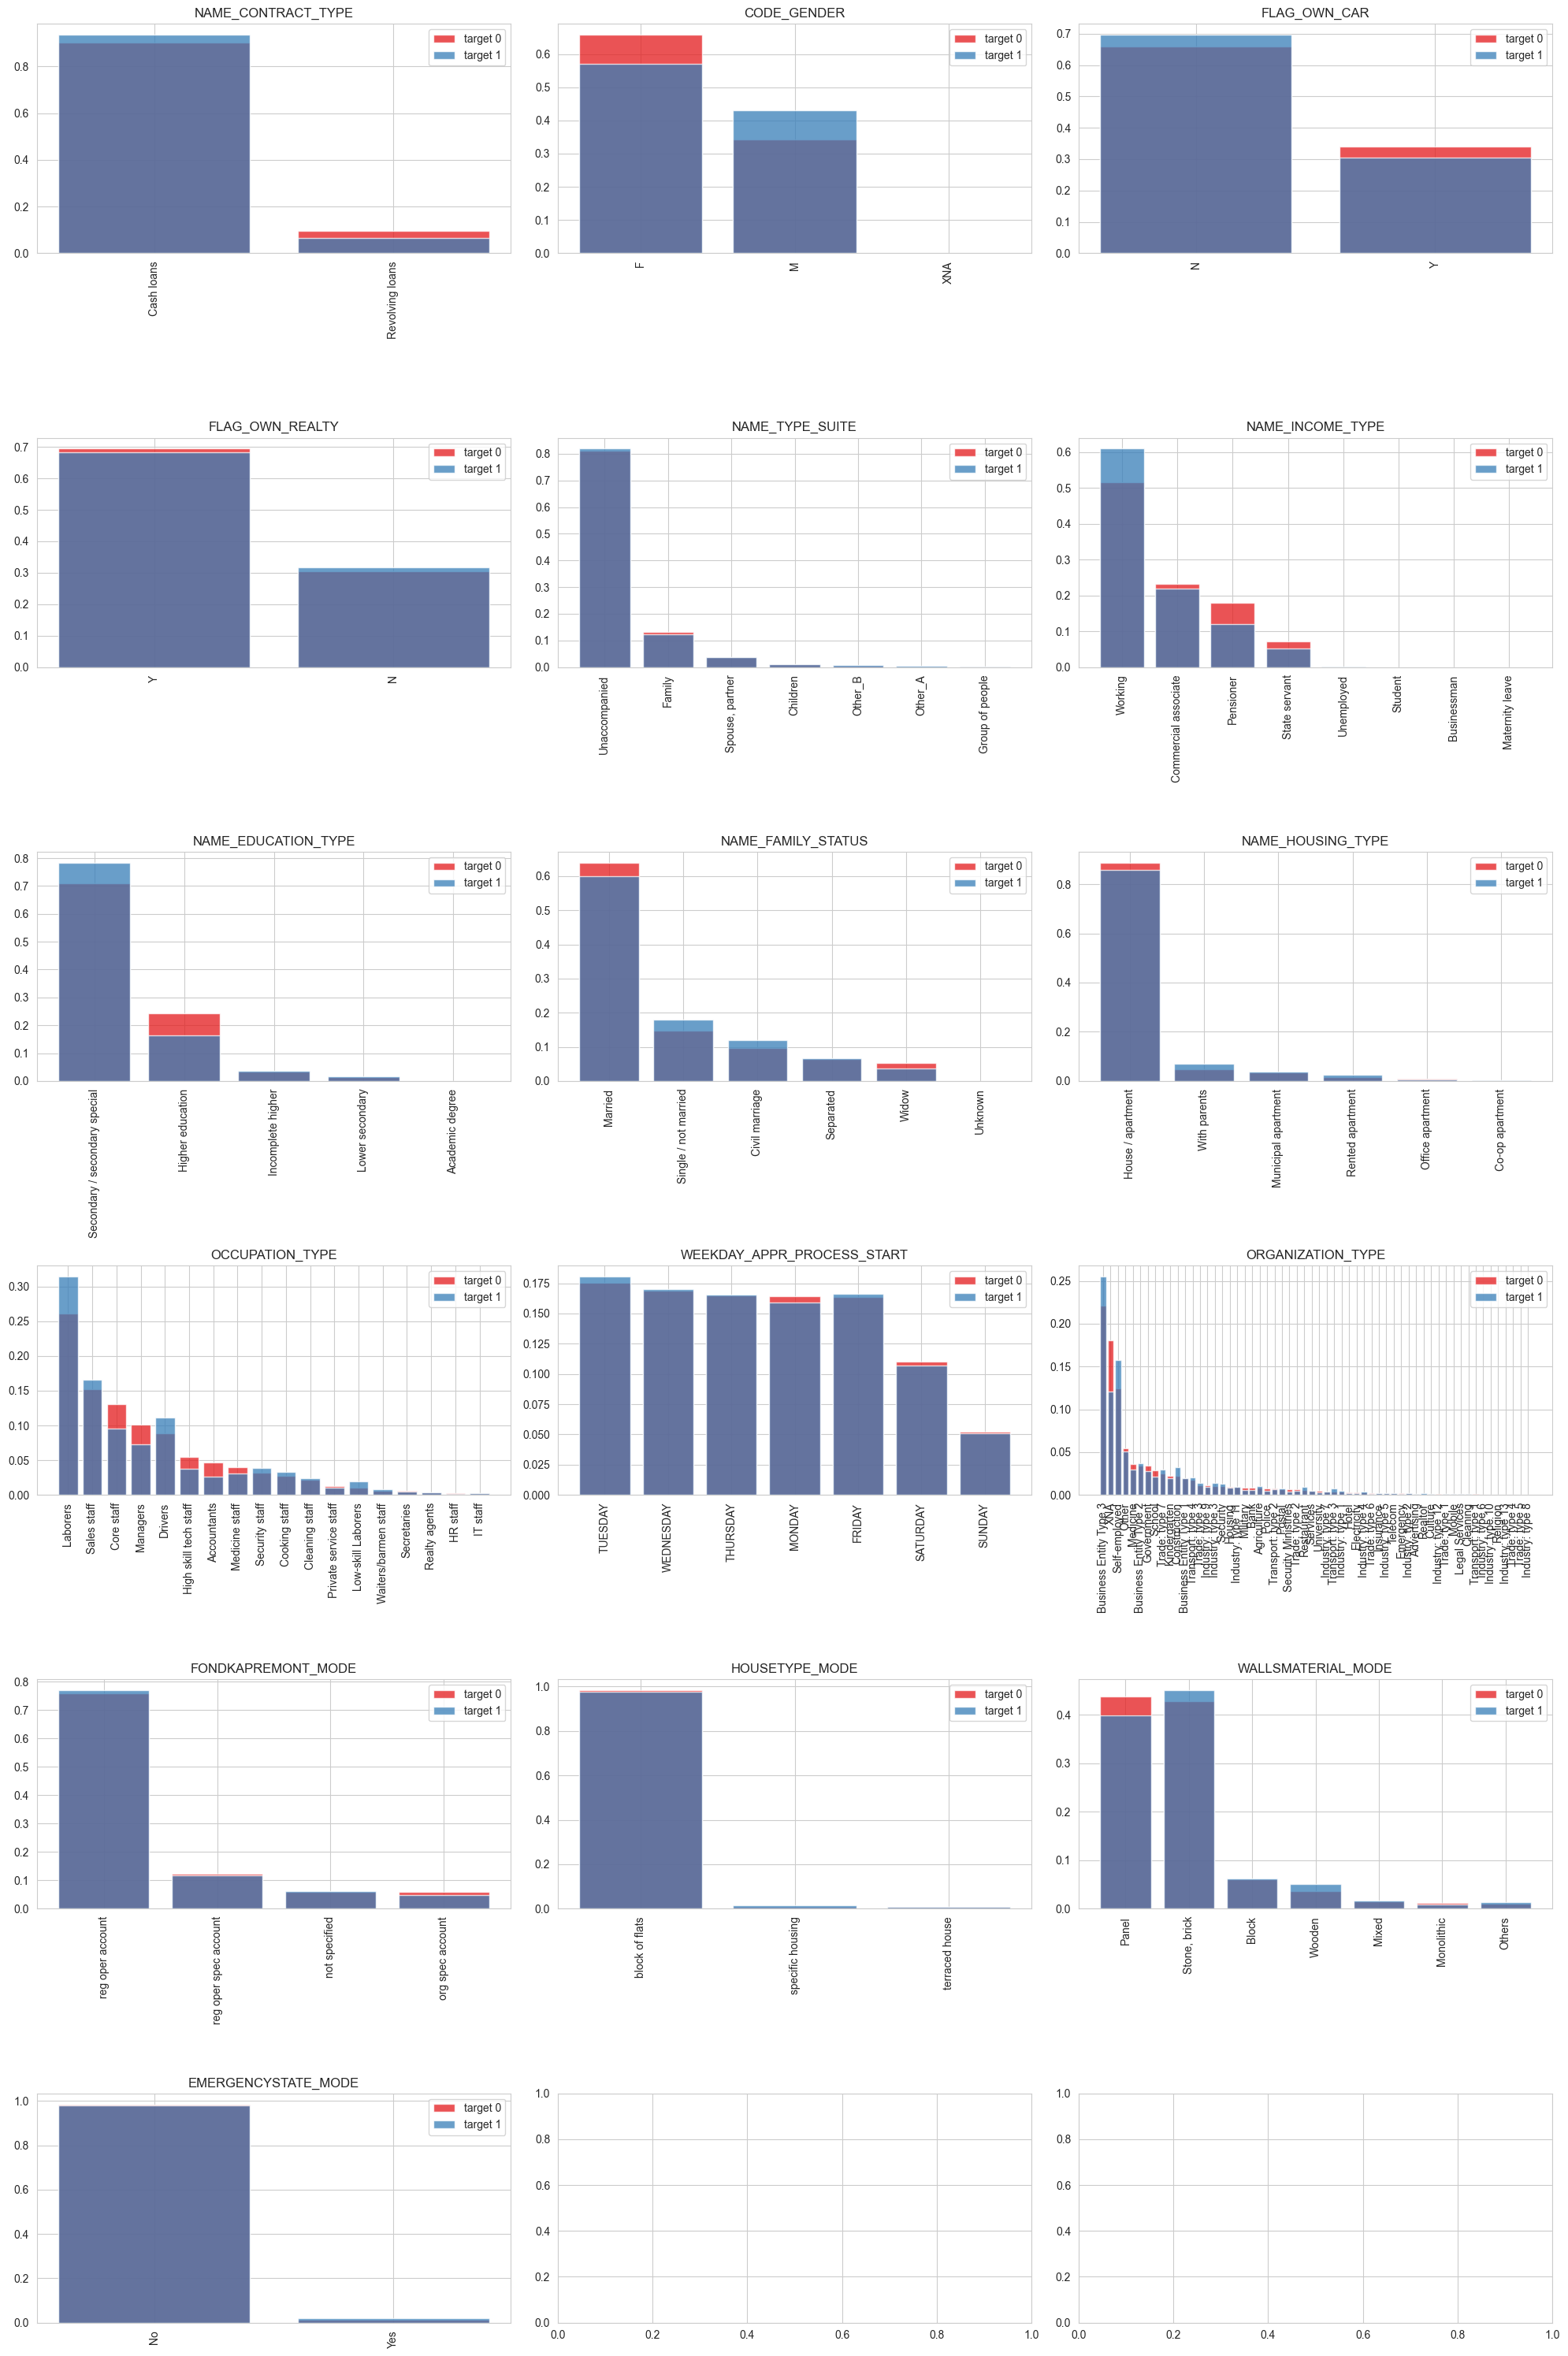

In [17]:
# Plot the distribution of the categorical features with hue = target
cols_to_plot = cat_cols
ncol, nrow = 3, len(cols_to_plot)//3 + 1
fig, ax = plt.subplots(nrow, ncol, figsize=(20, 30))

for i, col in enumerate(cols_to_plot):
    # normalized count plot
    ax[i//ncol, i%ncol].bar(df[col].value_counts(normalize=True).index, df[col].value_counts(normalize=True), label='target 0', alpha=0.75)
    ax[i//ncol, i%ncol].bar(df.loc[df['TARGET'] == 1, col].value_counts(normalize=True).index, df.loc[df['TARGET'] == 1, col].value_counts(normalize=True), label='target 1', alpha=0.75)
    ax[i//ncol, i%ncol].set_xticks(df[col].value_counts(normalize=True).index)
    ax[i//ncol, i%ncol].set_xticklabels(df[col].value_counts(normalize=True).index, rotation=90)
    ax[i//ncol, i%ncol].set_title(col)
    ax[i//ncol, i%ncol].legend()

plt.tight_layout()
plt.show()

- CODE_GENDER: Số lượng nữ vay tiền nhiều hơn nam nhưng khả năng nam trả được nợ lại thấp hơn khách hàng nữ.
- Phần lớn khách hàng đều vay tiền mặt cho cả 2 tệp khách hàng.
- Hầu hết khoản vay thì đều được Laborers và sale staff đăng kí, IT staff và HR staff chiếm số lượng ít nhất.
- Khách hàng mà có % không trả được nợ cao nhất là Người lao động trình độ thấp, tài xế, phục vụ, bảo vệ,...
- Hầu hết đơn đăng kí được đến từ khách hàng có nguồn thu nhập từ việc lao động (Working), sau đó là commercial association, người nghỉ hưu và người làm việc cho nhà nước.
- Đa số người vay có tình độ học vấn trung học cơ sơ/ trung học đặc biệt, sau đó là khách hàng có bằng đại học.

## Missing Values

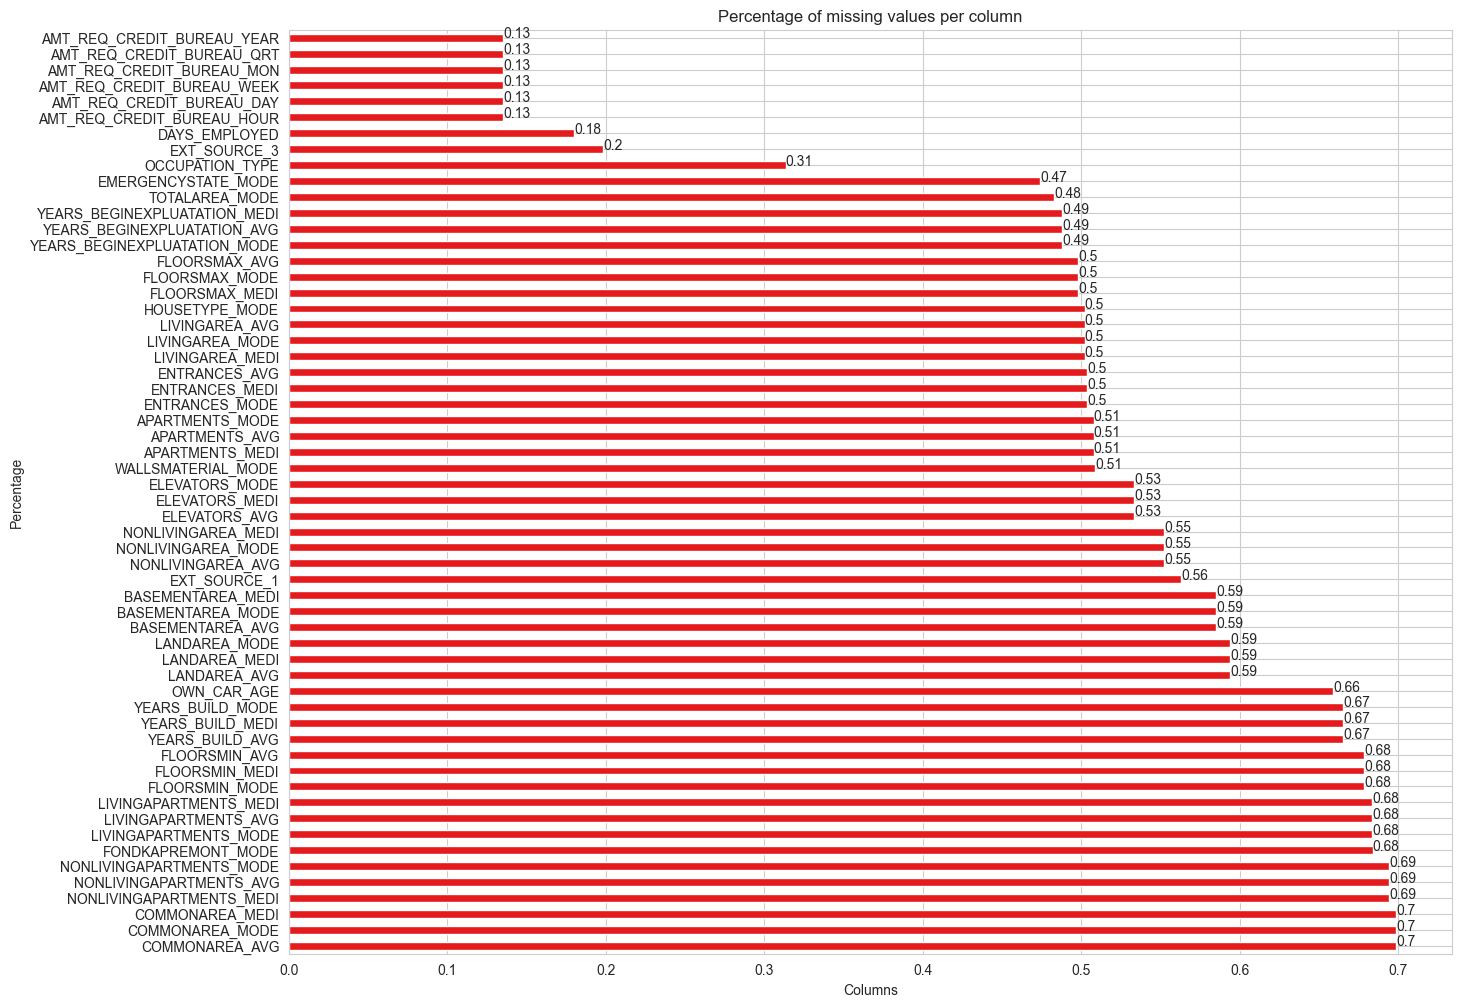

In [18]:
# Bar plot number of missing values column >10% ascending 
cols_with_null = df.isnull().mean() > 0.1
cols_with_null = cols_with_null[cols_with_null == True]
cols_with_null = cols_with_null.index
df[cols_with_null].isnull().mean().sort_values(ascending=False).plot(kind='barh', figsize=(15, 12))
# annotate bar plot
for index, value in enumerate(df[cols_with_null].isnull().mean().sort_values(ascending=False)):
    plt.text(value, index, str(round(value, 2)))
plt.title('Percentage of missing values per column')
plt.ylabel('Percentage')
plt.xlabel('Columns')
plt.show()

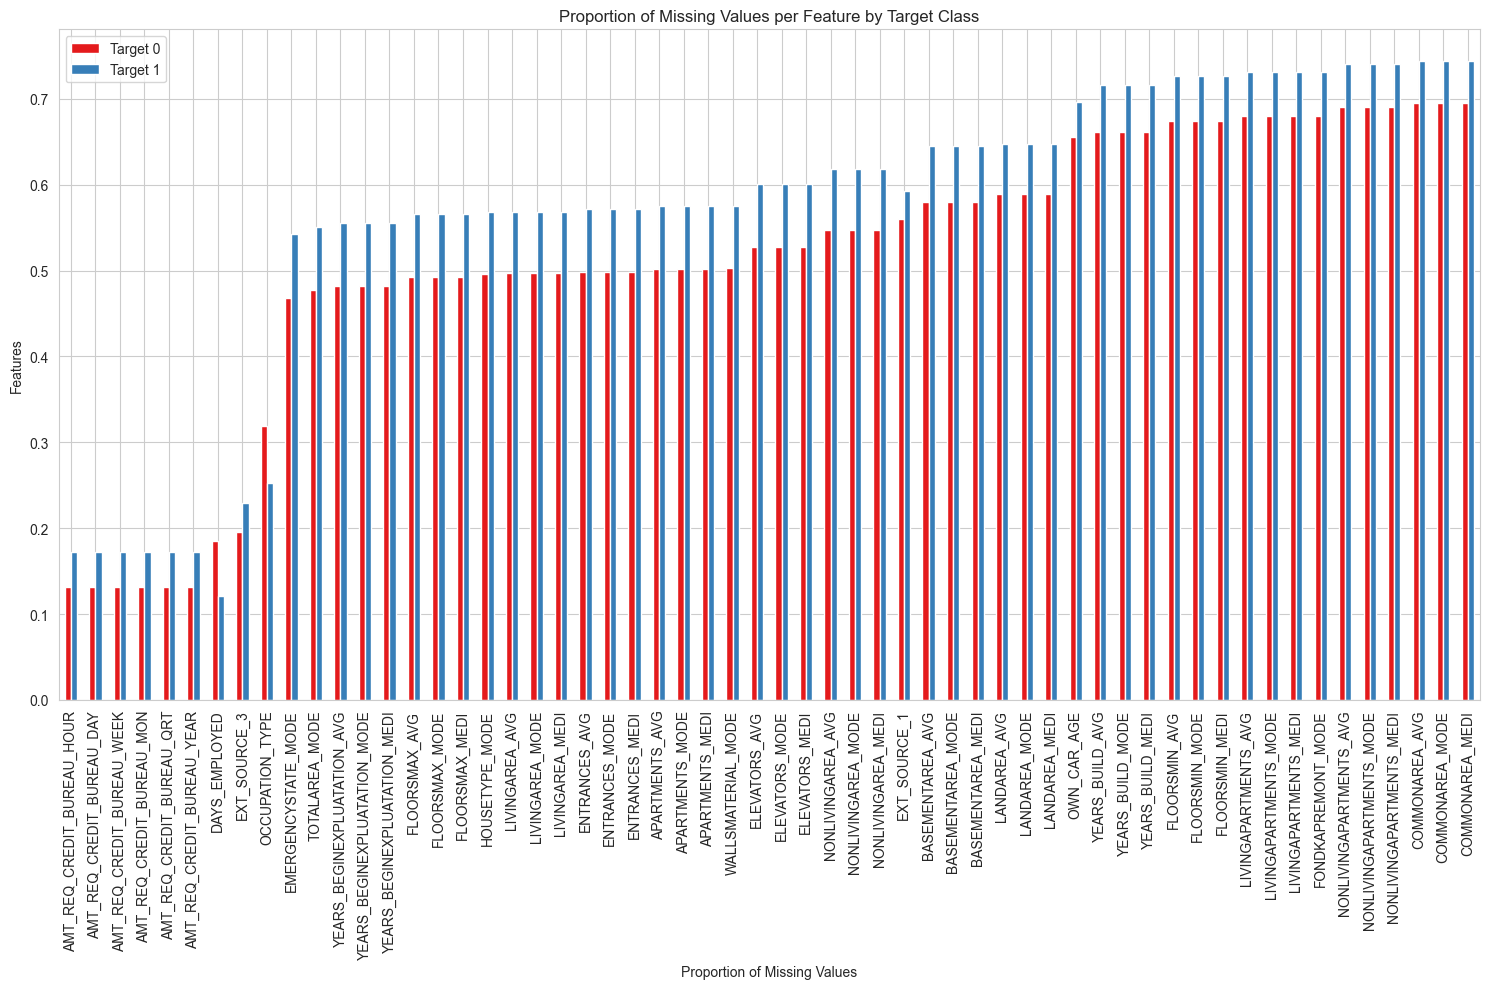

In [19]:
# Plot proportion of missing values each column hue = target
cols_to_plot = cols_with_null
data = []

for col in cols_to_plot:
    null_class_0 = df.loc[df['TARGET'] == 0, col].isnull().mean()
    null_class_1 = df.loc[df['TARGET'] == 1, col].isnull().mean()
    data.append({'Feature': col, 'Target 0': null_class_0, 'Target 1': null_class_1})

missing_df = pd.DataFrame(data)

# Plotting
fig, ax = plt.subplots(figsize=(15, 10))

# Stacked bar chart
missing_df.sort_values(by=['Target 0', 'Target 1'], ascending=True, inplace=True)
missing_df.set_index('Feature').plot(kind='bar', stacked=False, ax=ax)

ax.set_xlabel('Proportion of Missing Values')
ax.set_ylabel('Features')
ax.set_title('Proportion of Missing Values per Feature by Target Class')

plt.tight_layout()
plt.show()

There's an interesting find that the percentage of clients missing information in class 1 is significantly higher than in class 0.

-> Feature engineer to indicate missing values of customers.

## Correlation

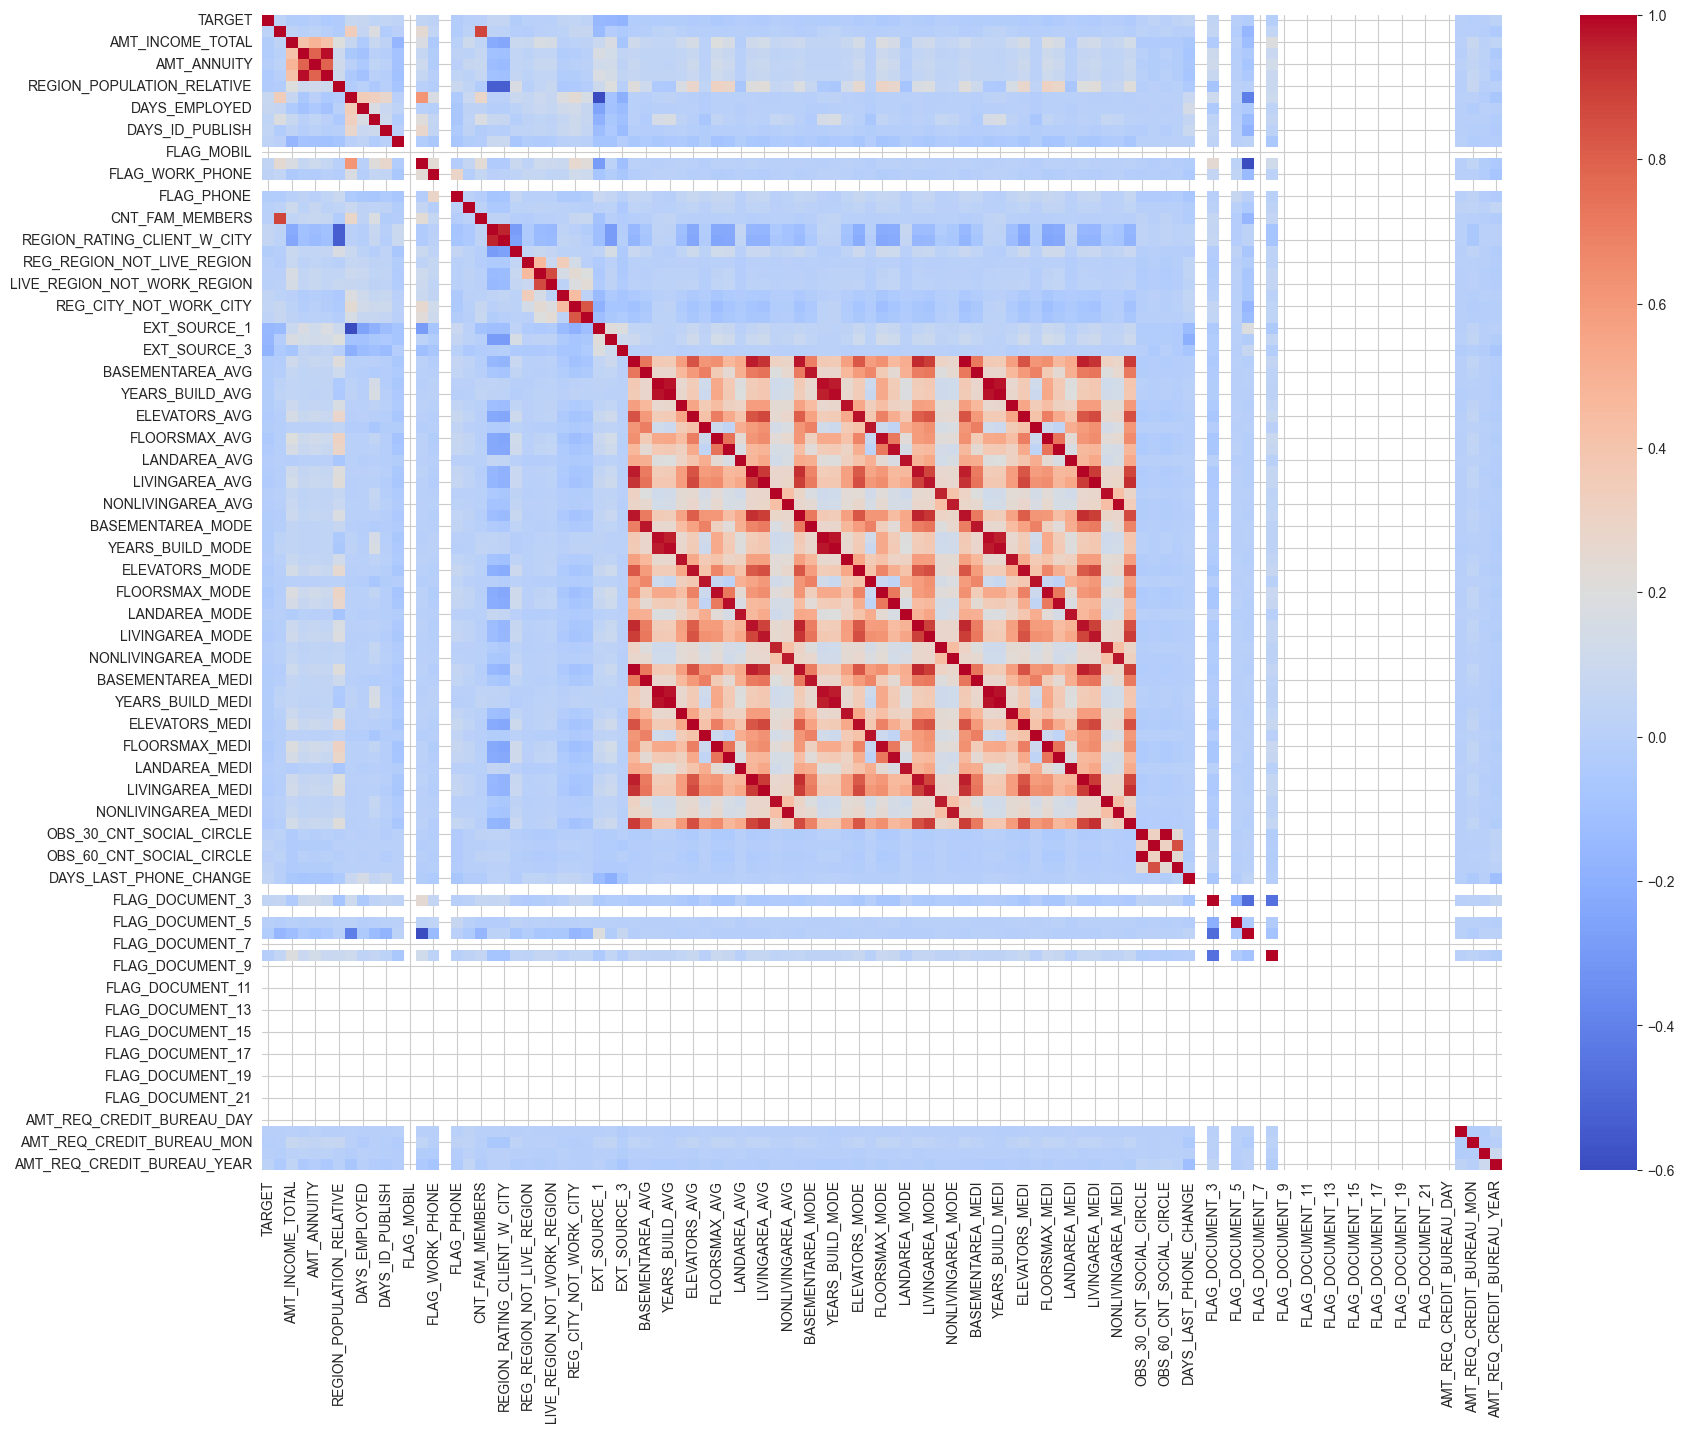

In [20]:
# Plot correlation matrix
corr = df[num_cols].corr()
plt.figure(figsize=(20, 15))
sns.heatmap(corr, cmap='coolwarm')
plt.show()

In [21]:
# Filter out highly correlated features
high_corr_cols = []
for i in range(len(corr)):
    for j in range(i+1, len(corr)):
        if 1 > abs(corr.iloc[i, j]) > 0.9:
            high_corr_cols.append(corr.columns[j])
            print(f'{corr.columns[i]}, {corr.columns[j]}: {corr.iloc[i, j]}')

AMT_CREDIT, AMT_GOODS_PRICE: 0.9864087940029821
REGION_RATING_CLIENT, REGION_RATING_CLIENT_W_CITY: 0.9509880039018394
APARTMENTS_AVG, LIVINGAPARTMENTS_AVG: 0.9652110140044691
APARTMENTS_AVG, LIVINGAREA_AVG: 0.921730716109641
APARTMENTS_AVG, APARTMENTS_MODE: 0.9718797762659463
APARTMENTS_AVG, LIVINGAPARTMENTS_MODE: 0.9433272695958759
APARTMENTS_AVG, APARTMENTS_MEDI: 0.9956509539146213
APARTMENTS_AVG, LIVINGAPARTMENTS_MEDI: 0.9620269902806999
APARTMENTS_AVG, LIVINGAREA_MEDI: 0.9194509537303049
APARTMENTS_AVG, TOTALAREA_MODE: 0.9011978822068946
BASEMENTAREA_AVG, BASEMENTAREA_MODE: 0.9719660031663897
BASEMENTAREA_AVG, BASEMENTAREA_MEDI: 0.9957212948818687
YEARS_BEGINEXPLUATATION_AVG, YEARS_BUILD_AVG: 0.978886289629439
YEARS_BEGINEXPLUATATION_AVG, YEARS_BEGINEXPLUATATION_MODE: 0.9868700890035477
YEARS_BEGINEXPLUATATION_AVG, YEARS_BUILD_MODE: 0.9684142812384173
YEARS_BEGINEXPLUATATION_AVG, YEARS_BEGINEXPLUATATION_MEDI: 0.9962367905488781
YEARS_BEGINEXPLUATATION_AVG, YEARS_BUILD_MEDI: 0.97743

In [22]:
len(high_corr_cols)

76

# Feature Importance

In [23]:
# Plot feature importance by IV and WoE
optb = BinningProcess(variable_names=df.columns.to_list())
optb.fit(df, df['TARGET'])
optb.summary()

name        dtype   status  selected n_bins  \
0                        TARGET    numerical  OPTIMAL      True      1   
1            NAME_CONTRACT_TYPE  categorical  OPTIMAL      True      2   
2                   CODE_GENDER  categorical  OPTIMAL      True      2   
3                  FLAG_OWN_CAR  categorical  OPTIMAL      True      2   
4               FLAG_OWN_REALTY  categorical  OPTIMAL      True      2   
..                          ...          ...      ...       ...    ...   
116   AMT_REQ_CREDIT_BUREAU_DAY    numerical  OPTIMAL      True      1   
117  AMT_REQ_CREDIT_BUREAU_WEEK    numerical  OPTIMAL      True      1   
118   AMT_REQ_CREDIT_BUREAU_MON    numerical  OPTIMAL      True      2   
119   AMT_REQ_CREDIT_BUREAU_QRT    numerical  OPTIMAL      True      3   
120  AMT_REQ_CREDIT_BUREAU_YEAR    numerical  OPTIMAL      True      5   

           iv        js      gini quality_score  
0         0.0       0.0         0           0.0  
1      0.0159  0.001974  0.034215       0.01526  
2    0.038714   0.00483  0.095413      0.096336  
3    0.007429  0.000928  0.040314      0.018538  
4    0.000647  0.000081  0.011771      0.001525  
..        ...       ...       ...           ...  
116  0.012852  0.001602  0.040599      0.018748  
117  0.012852  0.001602  0.040599      0.018748  
118  0.013412  0.001672  0.047378      0.032648  
119    0.0164  0.002045  0.057595       0.04068  
120  0.017215  0.002147  0.068541      0.025693  

[121 rows x 9 columns]

In [24]:
summary = optb.summary().set_index('name')
summary.sort_values(by='iv', ascending=False, inplace=True)
summary.head(20)

dtype   status  selected n_bins        iv  \
name                                                                           
EXT_SOURCE_3                   numerical  OPTIMAL      True     12  0.340914   
EXT_SOURCE_2                   numerical  OPTIMAL      True     14  0.315041   
EXT_SOURCE_1                   numerical  OPTIMAL      True      5  0.145015   
DAYS_EMPLOYED                  numerical  OPTIMAL      True     10  0.112339   
AMT_GOODS_PRICE                numerical  OPTIMAL      True      9  0.095829   
DAYS_BIRTH                     numerical  OPTIMAL      True     14  0.086207   
OCCUPATION_TYPE              categorical  OPTIMAL      True      6  0.077268   
ORGANIZATION_TYPE            categorical  OPTIMAL      True      8  0.072775   
AMT_CREDIT                     numerical  OPTIMAL      True     10  0.062098   
NAME_INCOME_TYPE             categorical  OPTIMAL      True      4  0.055244   
REGION_RATING_CLIENT_W_CITY    numerical  OPTIMAL      True      3  0.050405   
NAME_EDUCATION_TYPE          categorical  OPTIMAL      True      2  0.048225   
REGION_RATING_CLIENT           numerical  OPTIMAL      True      3  0.046664   
DAYS_LAST_PHONE_CHANGE         numerical  OPTIMAL      True     10  0.045678   
DAYS_ID_PUBLISH                numerical  OPTIMAL      True     11  0.041005   
CODE_GENDER                  categorical  OPTIMAL      True      2  0.038714   
FLOORSMAX_AVG                  numerical  OPTIMAL      True      4  0.038227   
FLOORSMAX_MEDI                 numerical  OPTIMAL      True      4  0.037867   
FLOORSMAX_MODE                 numerical  OPTIMAL      True      4  0.037313   
TOTALAREA_MODE                 numerical  OPTIMAL      True      6  0.036881   

                                   js      gini quality_score  
name                                                           
EXT_SOURCE_3                 0.041182  0.318083      0.698405  
EXT_SOURCE_2                 0.038044  0.307826      0.163551  
EXT_SOURCE_1                 0.017618  0.176302      0.424698  
DAYS_EMPLOYED                0.013934  0.185914      0.075265  
AMT_GOODS_PRICE              0.011834  0.166753      0.167561  
DAYS_BIRTH                   0.010688  0.165341      0.021156  
OCCUPATION_TYPE              0.009619  0.148418      0.173918  
ORGANIZATION_TYPE            0.009045  0.147968      0.121178  
AMT_CREDIT                   0.007698   0.13438      0.217831  
NAME_INCOME_TYPE             0.006871  0.119035      0.168986  
REGION_RATING_CLIENT_W_CITY  0.006245  0.097867      0.106849  
NAME_EDUCATION_TYPE           0.00599  0.088508      0.098281  
REGION_RATING_CLIENT         0.005784  0.094738       0.10123  
DAYS_LAST_PHONE_CHANGE       0.005686  0.112663      0.004212  
DAYS_ID_PUBLISH               0.00511  0.114234      0.003481  
CODE_GENDER                   0.00483  0.095413      0.096336  
FLOORSMAX_AVG                0.004756  0.096192      0.129141  
FLOORSMAX_MEDI               0.004711  0.095861      0.127624  
FLOORSMAX_MODE               0.004643  0.095388      0.125512  
TOTALAREA_MODE               0.004593  0.096226      0.015915

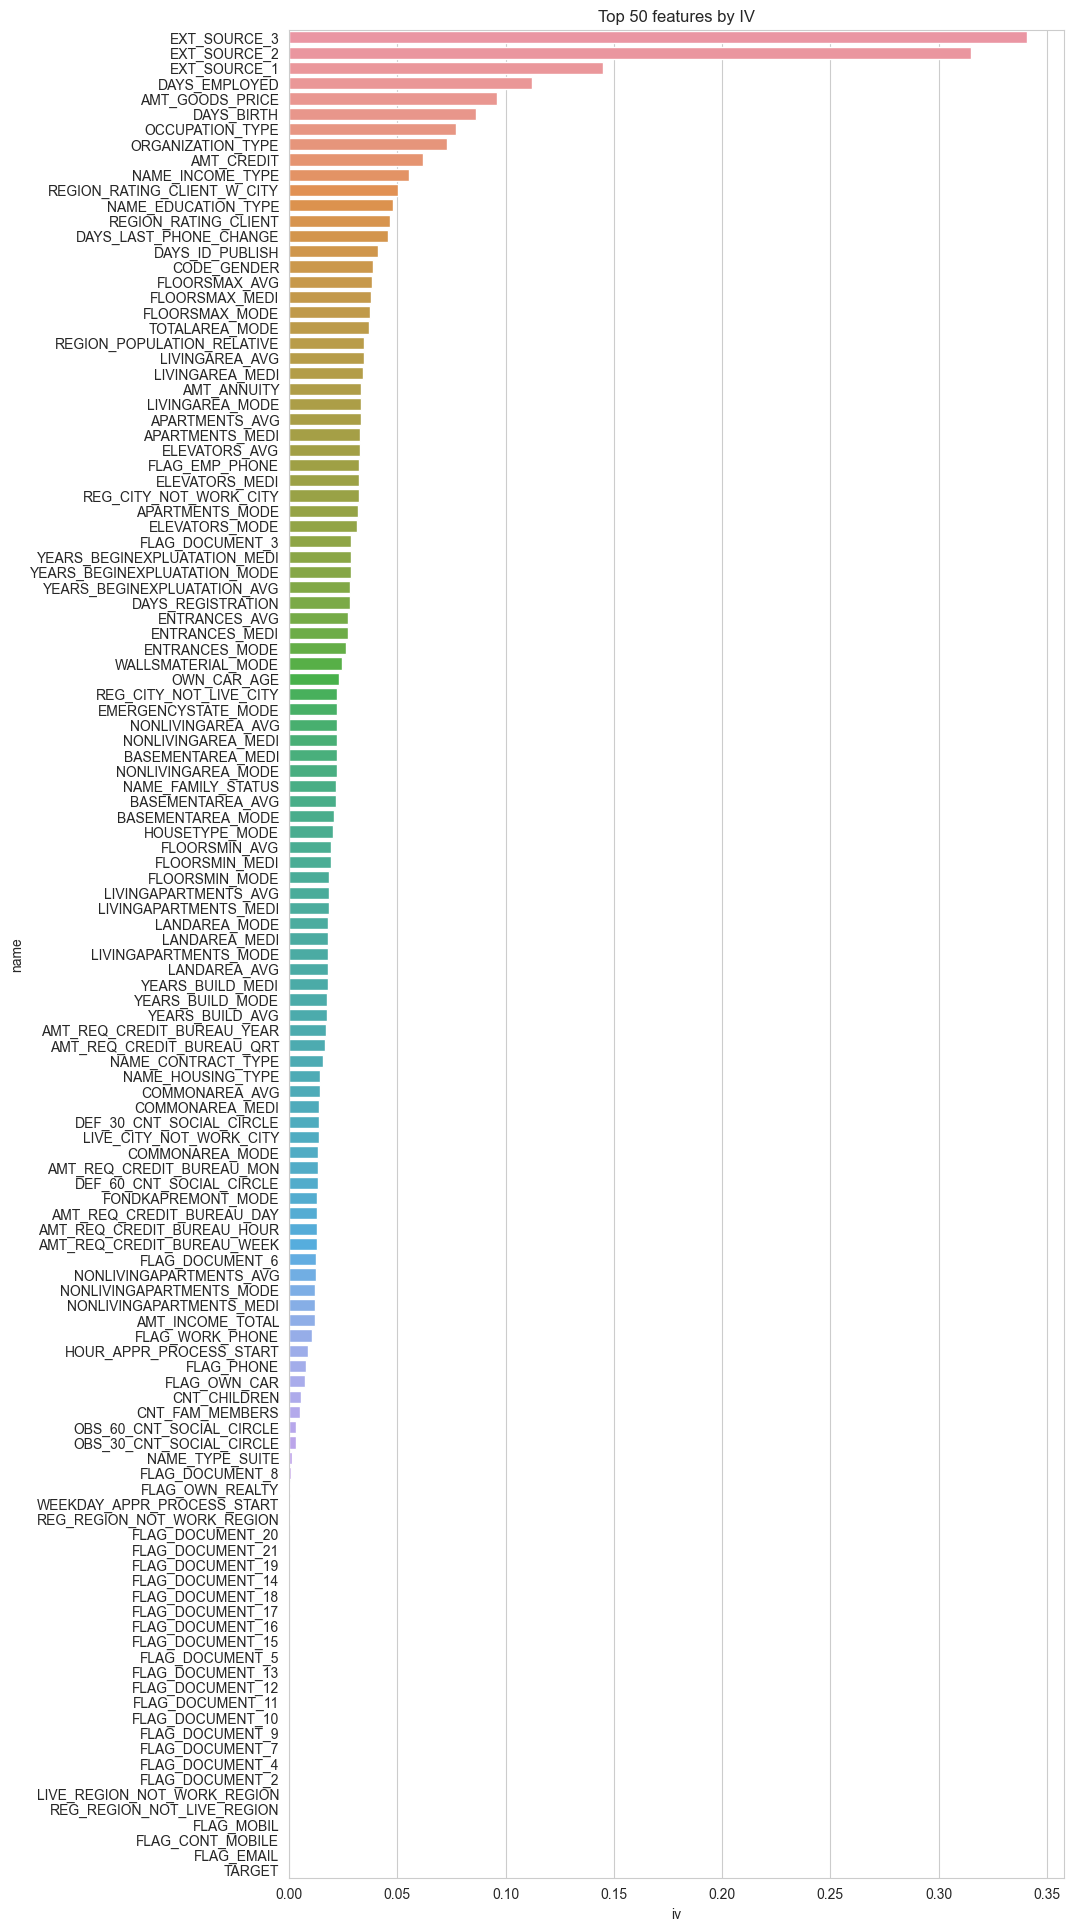

In [25]:
top50 = summary.copy()

# Plot feature importance by IV and WoE
plt.figure(figsize=(10, len(top50)//5))
sns.barplot(x='iv', y=top50.index, data=top50)
plt.title('Top 50 features by IV')
plt.show()

In [26]:
df = df_copy.copy()

In [27]:
# Prepare data for modelling
# Union cols with null and highly correlated cols
var_0_cols = df.select_dtypes('number').var()[df.select_dtypes('number').var() < 1e-3].index.tolist()
cols_with_null = df[df.columns[df.isnull().mean() > 0.6]].columns.tolist()
cols_to_drop = var_0_cols + high_corr_cols + cols_with_null
cols_to_drop = set(cols_to_drop)
len(cols_to_drop)

51

In [28]:
# Drop cols
df.drop(cols_to_drop, axis=1, inplace=True)
df.shape

(246009, 70)

In [29]:
df

TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
SK_ID_CURR                                                       
278621           0         Cash loans           F            N   
139008           0         Cash loans           F            N   
138348           0         Cash loans           M            N   
64140            0         Cash loans           M            N   
219374           0         Cash loans           M            Y   
...            ...                ...         ...          ...   
90253            0         Cash loans           M            N   
9027             0         Cash loans           F            N   
163598           0         Cash loans           F            N   
300375           1         Cash loans           F            N   
258328           0         Cash loans           F            N   

           FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
SK_ID_CURR                                                               
278621                   N             0          270000.0   1293502.5   
139008                   Y             0          135000.0    312682.5   
138348                   Y             0          121500.0    513000.0   
64140                    Y             0           99000.0    490495.5   
219374                   Y             0          360000.0   1530000.0   
...                    ...           ...               ...         ...   
90253                    N             0          157500.0    254700.0   
9027                     Y             0           72000.0    269550.0   
163598                   Y             0          153000.0    677664.0   
300375                   Y             0          171000.0    370107.0   
258328                   N             0          157500.0    675000.0   

            AMT_ANNUITY  NAME_TYPE_SUITE  ... FLAG_DOCUMENT_14  \
SK_ID_CURR                                ...                    
278621          35698.5           Family  ...                0   
139008          29686.5    Unaccompanied  ...                0   
138348          21865.5    Unaccompanied  ...                0   
64140           27517.5  Spouse, partner  ...                0   
219374          42075.0    Unaccompanied  ...                0   
...                 ...              ...  ...              ...   
90253           27558.0    Unaccompanied  ...                0   
9027            12001.5    Unaccompanied  ...                0   
163598          29979.0    Unaccompanied  ...                0   
300375          20205.0    Unaccompanied  ...                0   
258328          49117.5    Unaccompanied  ...                0   

           FLAG_DOCUMENT_15 FLAG_DOCUMENT_16 FLAG_DOCUMENT_18  \
SK_ID_CURR                                                      
278621                    0                0                0   
139008                    0                0                0   
138348                    0                0                0   
64140                     0                0                0   
219374                    0                0                0   
...                     ...              ...              ...   
90253                     0                0                0   
9027                      0                0                0   
163598                    0                0                0   
300375                    0                0                0   
258328                    0                0                0   

            AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
SK_ID_CURR                                                          
278621                             0.0                        0.0   
139008                             NaN                        NaN   
138348                             0.0                        0.0   
64140                              0.0                        0.0   
219374                             0.0                        0.0   
..

In [30]:
# Preprocess 
cat_cols = df.select_dtypes(include='object').columns.tolist()
num_cols = df.select_dtypes(include=np.number).columns.tolist()

# Fill missing values
df[num_cols] = df[num_cols].fillna(df[num_cols].median())
df[cat_cols] = df[cat_cols].fillna('Missing')

# One hot encode categorical features
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

In [31]:
# Split data into train and test
X = df.drop('TARGET', axis=1)
y = df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Scale numerical features
scaler = StandardScaler().set_output(transform='pandas')
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train logistic regression model
model = LogisticRegression(solver='newton-cholesky', max_iter=200)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict_proba(X_test)[:, 1]

# Evaluate
print(f'ROC AUC score: {roc_auc_score(y_test, y_pred)}')
print(f'GINI score: {2*roc_auc_score(y_test, y_pred) - 1}')

ROC AUC score: 0.7437863072574287
GINI score: 0.48757261451485734


In [32]:
# Plot by coefficient
coef = pd.DataFrame({'Feature': X.columns, 'Coefficient': abs(model.coef_[0])})
coef.sort_values(by='Coefficient', ascending=False, inplace=True)
coef.head(30)

Feature  Coefficient
5                                        DAYS_EMPLOYED     5.429532
8                                       FLAG_EMP_PHONE     1.663897
68                          NAME_INCOME_TYPE_Pensioner     1.654094
167                              ORGANIZATION_TYPE_XNA     1.650139
72                            NAME_INCOME_TYPE_Working     0.708395
66               NAME_INCOME_TYPE_Commercial associate     0.568628
76   NAME_EDUCATION_TYPE_Secondary / secondary special     0.550158
24                                        EXT_SOURCE_3     0.479182
73                NAME_EDUCATION_TYPE_Higher education     0.393487
23                                        EXT_SOURCE_2     0.384657
69                      NAME_INCOME_TYPE_State servant     0.339289
74               NAME_EDUCATION_TYPE_Incomplete higher     0.186751
37                                     FLAG_DOCUMENT_3     0.172317
55                                       CODE_GENDER_M     0.160107
22                                        EXT_SOURCE_1     0.159196
57                                      FLAG_OWN_CAR_Y     0.142467
75                 NAME_EDUCATION_TYPE_Lower secondary     0.140759
39                                     FLAG_DOCUMENT_6     0.102169
94                            OCCUPATION_TYPE_Laborers     0.093023
3                                          AMT_ANNUITY     0.091494
90                             OCCUPATION_TYPE_Drivers     0.072742
7                                      DAYS_ID_PUBLISH     0.072084
98                             OCCUPATION_TYPE_Missing     0.071505
14                                REGION_RATING_CLIENT     0.069658
77                          NAME_FAMILY_STATUS_Married     0.064837
101                        OCCUPATION_TYPE_Sales staff     0.062450
168                      HOUSETYPE_MODE_block of flats     0.060800
178                             EMERGENCYSTATE_MODE_No     0.060164
36                              DAYS_LAST_PHONE_CHANGE     0.059536
40                                     FLAG_DOCUMENT_8     0.057316

# Feature Engineering

In [33]:
df = df_copy.copy()
target = df['TARGET']
df.head()

TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
SK_ID_CURR                                                       
278621           0         Cash loans           F            N   
139008           0         Cash loans           F            N   
138348           0         Cash loans           M            N   
64140            0         Cash loans           M            N   
219374           0         Cash loans           M            Y   

           FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
SK_ID_CURR                                                               
278621                   N             0          270000.0   1293502.5   
139008                   Y             0          135000.0    312682.5   
138348                   Y             0          121500.0    513000.0   
64140                    Y             0           99000.0    490495.5   
219374                   Y             0          360000.0   1530000.0   

            AMT_ANNUITY  AMT_GOODS_PRICE  ... FLAG_DOCUMENT_18  \
SK_ID_CURR                                ...                    
278621          35698.5        1129500.0  ...                0   
139008          29686.5         297000.0  ...                0   
138348          21865.5         513000.0  ...                0   
64140           27517.5         454500.0  ...                0   
219374          42075.0        1530000.0  ...                0   

           FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
SK_ID_CURR                                                      
278621                    0                0                0   
139008                    0                0                0   
138348                    0                0                0   
64140                     0                0                0   
219374                    0                0                0   

           AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
SK_ID_CURR                                                         
278621                            0.0                        0.0   
139008                            NaN                        NaN   
138348                            0.0                        0.0   
64140                             0.0                        0.0   
219374                            0.0                        0.0   

            AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
SK_ID_CURR                                                          
278621                             0.0                        0.0   
139008                             NaN                        NaN   
138348                             0.0                        0.0   
64140                              0.0                        0.0   
219374                             0.0                        0.0   

            AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
SK_ID_CURR                                                         
278621                            0.0                         0.0  
139008                            NaN                         NaN  
138348                            0.0                         0.0  
64140                             1.0                         1.0  
219374                            0.0                         0.0  

[5 rows x 121 columns]

In [34]:
num_cols = df.select_dtypes(include=np.number).columns.tolist()
num_cols.remove('TARGET')

cat_cols = df.select_dtypes(include='object').columns.tolist()

In [35]:
# Replace XNA with np.nan
df.replace(['XNA', 'Unkown', 'not specified'], np.nan, inplace=True)
df

TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
SK_ID_CURR                                                       
278621           0         Cash loans           F            N   
139008           0         Cash loans           F            N   
138348           0         Cash loans           M            N   
64140            0         Cash loans           M            N   
219374           0         Cash loans           M            Y   
...            ...                ...         ...          ...   
90253            0         Cash loans           M            N   
9027             0         Cash loans           F            N   
163598           0         Cash loans           F            N   
300375           1         Cash loans           F            N   
258328           0         Cash loans           F            N   

           FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
SK_ID_CURR                                                               
278621                   N             0          270000.0   1293502.5   
139008                   Y             0          135000.0    312682.5   
138348                   Y             0          121500.0    513000.0   
64140                    Y             0           99000.0    490495.5   
219374                   Y             0          360000.0   1530000.0   
...                    ...           ...               ...         ...   
90253                    N             0          157500.0    254700.0   
9027                     Y             0           72000.0    269550.0   
163598                   Y             0          153000.0    677664.0   
300375                   Y             0          171000.0    370107.0   
258328                   N             0          157500.0    675000.0   

            AMT_ANNUITY  AMT_GOODS_PRICE  ... FLAG_DOCUMENT_18  \
SK_ID_CURR                                ...                    
278621          35698.5        1129500.0  ...                0   
139008          29686.5         297000.0  ...                0   
138348          21865.5         513000.0  ...                0   
64140           27517.5         454500.0  ...                0   
219374          42075.0        1530000.0  ...                0   
...                 ...              ...  ...              ...   
90253           27558.0         225000.0  ...                0   
9027            12001.5         225000.0  ...                0   
163598          29979.0         585000.0  ...                0   
300375          20205.0         319500.0  ...                0   
258328          49117.5         675000.0  ...                0   

           FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
SK_ID_CURR                                                      
278621                    0                0                0   
139008                    0                0                0   
138348                    0                0                0   
64140                     0                0                0   
219374                    0                0                0   
...                     ...              ...              ...   
90253                     0                0                0   
9027                      0                0                0   
163598                    0                0                0   
300375                    0                0                0   
258328                    0                0                0   

           AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
SK_ID_CURR                                                         
278621                            0.0                        0.0   
139008                            NaN                        NaN   
138348                            0.0                        0.0   
64140                             0.0                        0.0   
219374                            0.0                        0.0   
...      

In [36]:
# Drop cols with variance 0
var_0_cols = df.select_dtypes('number').var()[df.select_dtypes('number').var() < 1e-3].index.tolist()
df.drop(var_0_cols, axis=1, inplace=True, errors='ignore')

# Drop cols with > 60% missing values
cols_with_null = df[df.columns[df.isnull().mean() > 0.6]].columns.tolist()
df.drop(cols_with_null, axis=1, inplace=True)

# Drop highly correlated cols
df.drop(high_corr_cols, axis=1, inplace=True, errors='ignore')

# Print shape
df.shape

(246009, 70)

In [37]:
optb = BinningProcess(variable_names=df.columns.to_list())
optb.fit(df, df['TARGET'])
optb.summary()

name        dtype   status  selected n_bins  \
0                       TARGET    numerical  OPTIMAL      True      1   
1           NAME_CONTRACT_TYPE  categorical  OPTIMAL      True      2   
2                  CODE_GENDER  categorical  OPTIMAL      True      2   
3                 FLAG_OWN_CAR  categorical  OPTIMAL      True      2   
4              FLAG_OWN_REALTY  categorical  OPTIMAL      True      2   
..                         ...          ...      ...       ...    ...   
65   AMT_REQ_CREDIT_BUREAU_DAY    numerical  OPTIMAL      True      1   
66  AMT_REQ_CREDIT_BUREAU_WEEK    numerical  OPTIMAL      True      1   
67   AMT_REQ_CREDIT_BUREAU_MON    numerical  OPTIMAL      True      2   
68   AMT_REQ_CREDIT_BUREAU_QRT    numerical  OPTIMAL      True      3   
69  AMT_REQ_CREDIT_BUREAU_YEAR    numerical  OPTIMAL      True      5   

          iv        js      gini quality_score  
0        0.0       0.0         0           0.0  
1     0.0159  0.001974  0.034215       0.01526  
2    0.03871  0.004829   0.09542       0.09633  
3   0.007429  0.000928  0.040314      0.018538  
4   0.000647  0.000081  0.011771      0.001525  
..       ...       ...       ...           ...  
65  0.012852  0.001602  0.040599      0.018748  
66  0.012852  0.001602  0.040599      0.018748  
67  0.013412  0.001672  0.047378      0.032648  
68    0.0164  0.002045  0.057595       0.04068  
69  0.017215  0.002147  0.068541      0.025693  

[70 rows x 9 columns]

In [38]:
summary = optb.summary().set_index('name')
summary.sort_values(by='gini', ascending=False, inplace=True)
summary.head(20)

dtype   status  selected n_bins        iv  \
name                                                                           
EXT_SOURCE_3                   numerical  OPTIMAL      True     12  0.340914   
EXT_SOURCE_2                   numerical  OPTIMAL      True     14  0.315041   
DAYS_EMPLOYED                  numerical  OPTIMAL      True     12  0.112837   
EXT_SOURCE_1                   numerical  OPTIMAL      True      5  0.145015   
DAYS_BIRTH                     numerical  OPTIMAL      True     14  0.086207   
OCCUPATION_TYPE              categorical  OPTIMAL      True      6  0.077268   
ORGANIZATION_TYPE            categorical  OPTIMAL      True      8  0.072775   
AMT_CREDIT                     numerical  OPTIMAL      True     10  0.062098   
NAME_INCOME_TYPE             categorical  OPTIMAL      True      4  0.055244   
DAYS_ID_PUBLISH                numerical  OPTIMAL      True     11  0.041005   
DAYS_LAST_PHONE_CHANGE         numerical  OPTIMAL      True     10  0.045678   
AMT_ANNUITY                    numerical  OPTIMAL      True      9  0.033361   
FLOORSMAX_AVG                  numerical  OPTIMAL      True      4  0.038227   
CODE_GENDER                  categorical  OPTIMAL      True      2   0.03871   
REGION_RATING_CLIENT           numerical  OPTIMAL      True      3  0.046664   
APARTMENTS_AVG                 numerical  OPTIMAL      True      6  0.033101   
NAME_EDUCATION_TYPE          categorical  OPTIMAL      True      2  0.048225   
ELEVATORS_AVG                  numerical  OPTIMAL      True      4  0.032755   
YEARS_BEGINEXPLUATATION_AVG    numerical  OPTIMAL      True      6  0.028341   
ENTRANCES_AVG                  numerical  OPTIMAL      True      5  0.027244   

                                   js      gini quality_score  
name                                                           
EXT_SOURCE_3                 0.041182  0.318083      0.698405  
EXT_SOURCE_2                 0.038044  0.307826      0.163551  
DAYS_EMPLOYED                0.013995  0.187207      0.193191  
EXT_SOURCE_1                 0.017618  0.176302      0.424698  
DAYS_BIRTH                   0.010688  0.165341      0.021156  
OCCUPATION_TYPE              0.009619  0.148418      0.173918  
ORGANIZATION_TYPE            0.009045  0.148025      0.124951  
AMT_CREDIT                   0.007698   0.13438      0.217831  
NAME_INCOME_TYPE             0.006871  0.119035      0.168986  
DAYS_ID_PUBLISH               0.00511  0.114234      0.003481  
DAYS_LAST_PHONE_CHANGE       0.005686  0.112663      0.004212  
AMT_ANNUITY                  0.004153  0.097924      0.123787  
FLOORSMAX_AVG                0.004756  0.096192      0.129141  
CODE_GENDER                  0.004829   0.09542       0.09633  
REGION_RATING_CLIENT         0.005784  0.094738       0.10123  
APARTMENTS_AVG               0.004126  0.091523      0.017447  
NAME_EDUCATION_TYPE           0.00599  0.088508      0.098281  
ELEVATORS_AVG                0.004075  0.088084      0.095734  
YEARS_BEGINEXPLUATATION_AVG  0.003532   0.08769      0.042382  
ENTRANCES_AVG                0.003399  0.086586      0.044137